### Download the dataset

In [1]:
import os
import shutil
try:
    shutil.rmtree("/content/hi")
except:
    pass

try:
    os.remove("/content/hi.zip")
except:
    pass

try:
    shutil.rmtree("/content/wandb")
except:
    pass

In [2]:
%%capture
!gdown https://drive.google.com/uc?id=1TkaNm9ucnEn3S5Pz3D5SRFiroFgx4fjs
!unzip "/content/hi.zip"
!pip install wandb

In [3]:
!nvidia-smi

Mon May 10 11:55:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbCallback

### Load the data

In [5]:
# Load the training lexicons
with open("hi/lexicons/hi.translit.sampled.train.tsv") as f:
    training_lines = f.readlines()
training_pairs = [line.strip("\n").split("\t") for line in training_lines]
training_map = dict([(example[1], example[0]) for example in training_pairs])

# Load the validation lexicons
with open("hi/lexicons/hi.translit.sampled.dev.tsv") as f:
    validation_lines = f.readlines()
validation_pairs = [line.strip("\n").split("\t") for line in validation_lines]
validation_map = dict([(example[1], example[0]) for example in validation_pairs])

# Load the test lexicons
with open("hi/lexicons/hi.translit.sampled.test.tsv") as f:
    test_lines = f.readlines()
test_pairs = [line.strip("\n").split("\t") for line in test_lines]
test_map = dict([(example[1], example[0]) for example in test_pairs])

# Number of training examples
M_train = len(training_map.keys())

# Number of validation examples
M_val = len(validation_map.keys())

# Number of test examples
M_test = len(test_map.keys())

print(f"Number of training examples = {M_train}")
print(f"Number of validation examples = {M_val}")
print(f"Number of test examples = {M_test}")
print()

Number of training examples = 41345
Number of validation examples = 4321
Number of test examples = 4442



### Prepare the data

We have used "tab" for the START sequence character and "newline" as the END sequence character.

In [6]:
def extract_data_info(data_dict):
    """
    Returns important information about the data.
    """
    input_words = []
    target_words = []
    input_characters = []
    target_characters = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")
        # Add the characters to the respective character lists
        input_characters = list(set(input_characters + list(key)))
        target_characters = list(set(target_characters + list(data_dict[key])))

    # Sort the input characters
    input_characters = sorted(list(set(input_characters)))
    # Sort the target characters
    target_characters = target_characters + ["\t", "\n"]
    target_characters = sorted(list(set(target_characters)))

    # Number of unique tokens in the source language
    num_input_tokens = len(input_characters)
    # Number of unique tokens in the target language
    num_target_tokens = len(target_characters)

    # Max input word length
    max_encoder_seq_length = max([len(word) for word in input_words])
    # Max output word length
    max_decoder_seq_length = max([len(word) for word in target_words])

    print(f"Number of unique input characters: {num_input_tokens}")
    print(f"Number of unique output characters: {num_target_tokens}")
    print()
    print(f"Maximum sequence length for the input: {max_encoder_seq_length}")
    print(f"Maximum sequence length for the output: {max_decoder_seq_length}")

    # Map characters to numerical indices (using +1 to avoid any character being mapped to 0)
    input_char_map = dict([(ch, i + 1) for i, ch in enumerate(input_characters)])
    target_char_map = dict([(ch, i + 1) for i, ch in enumerate(target_characters)])

    return input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map

def make_one_hot_arrays(data_dict, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens):
    """
    This function takes the training/validation/test dictionary as input and produces
    the one-hot encoded versions of the respective data.
    """
    input_words = []
    target_words = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")

    M = len(data_dict.keys())
    encoder_input_array = np.zeros((M, max_encoder_seq_length, num_input_tokens + 1), dtype="float")
    decoder_input_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")
    decoder_output_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")

    for i in range(M):
        source_word = input_words[i]
        target_word = target_words[i]

        # One-hot encoding for the input
        for j, ch in enumerate(source_word):
            encoder_input_array[i, j, input_char_map[ch]] = 1.0

        # One-hot encoding for the output
        for j, ch in enumerate(target_word):
            decoder_input_array[i, j, target_char_map[ch]]= 1.0
            if j >= 1:
                # The decoder output is one step ahead of the decoder input
                decoder_output_array[i, j-1, target_char_map[ch]] = 1.0

    return input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array

In [7]:
input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map = extract_data_info(training_map)

Number of unique input characters: 26
Number of unique output characters: 64

Maximum sequence length for the input: 20
Maximum sequence length for the output: 21


In [8]:
# Get the one-hot training matrices
input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array = make_one_hot_arrays(training_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_encoder_input_array = keras.preprocessing.sequence.pad_sequences(encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_decoder_input_array = keras.preprocessing.sequence.pad_sequences(decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_decoder_output_array = keras.preprocessing.sequence.pad_sequences(decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_decoder_output_array_oh = np.zeros((padded_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_decoder_output_array_oh[i][j][padded_decoder_output_array[i][j]] = 1.0

In [9]:
# Get the one-hot validation matrices
val_input_words, val_target_words, val_encoder_input_array, val_decoder_input_array, val_decoder_output_array = make_one_hot_arrays(validation_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_val_encoder_input_array = keras.preprocessing.sequence.pad_sequences(val_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_val_decoder_input_array = keras.preprocessing.sequence.pad_sequences(val_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_val_decoder_output_array = keras.preprocessing.sequence.pad_sequences(val_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_val_decoder_output_array_oh = np.zeros((padded_val_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_val_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_val_decoder_output_array_oh[i][j][padded_val_decoder_output_array[i][j]] = 1.0

In [10]:
# Get the one-hot validation matrices
test_input_words, test_target_words, test_encoder_input_array, test_decoder_input_array, test_decoder_output_array = make_one_hot_arrays(test_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_test_encoder_input_array = keras.preprocessing.sequence.pad_sequences(test_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_test_decoder_input_array = keras.preprocessing.sequence.pad_sequences(test_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_test_decoder_output_array = keras.preprocessing.sequence.pad_sequences(test_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_test_decoder_output_array_oh = np.zeros((padded_test_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_test_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_test_decoder_output_array_oh[i][j][padded_test_decoder_output_array[i][j]] = 1.0

In [11]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_array = np.argmax(encoder_input_array, axis=2)
val_encoder_input_array = np.argmax(val_encoder_input_array, axis=2)
test_encoder_input_array = np.argmax(test_encoder_input_array, axis=2)

decoder_input_array = np.argmax(decoder_input_array, axis=2)
val_decoder_input_array = np.argmax(val_decoder_input_array, axis=2)
test_decoder_input_array = np.argmax(test_decoder_input_array, axis=2)

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())
reverse_target_char_map[0] = "\n"

### Define the model

In [12]:
def define_model(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    num_cells: Number of cells in the encoder and decoder layers
    cell_type: choice of cell type: Simple RNN, LSTM, GRU
    num_encoder_layers: Number of layers in the encoder
    num_decoder_layers: Number of layers in the decoder
    input_embedding_size: Dimenions of the vector to represent each character
    dropout_fraction: fraction of neurons to drop out
    """
    ## ENCODER
    # encoder_input = keras.Input(shape=(None, num_input_tokens), name="EncoderInput")
    encoder_input = keras.Input(shape=(None, ), name="EncoderInput")
    encoder_embedding = keras.layers.Embedding(num_input_tokens + 1, input_embedding_size, name="EncoderInputEmbedding", mask_zero=True)(encoder_input)

    # LSTM/RNN/GRU layer of the encoder
    for i in range(1, num_encoder_layers+1):
        if cell_type=="LSTM":
            if i==num_encoder_layers:
                encoder = keras.layers.LSTM(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.LSTM(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)

            if i==1:
                encoder_outputs, encoder_state_h_1, encoder_state_c_1 = encoder(encoder_embedding)
            if i==2:
                encoder_outputs, encoder_state_h_2, encoder_state_c_2 = encoder(encoder_outputs)
            if i==3:
                encoder_outputs, encoder_state_h_3, encoder_state_c_3 = encoder(encoder_outputs)

        if cell_type=="RNN":
            if i==num_encoder_layers:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, rnn_final_state_1 = encoder(encoder_embedding)
            if i==2:
                whole_sequence_output, rnn_final_state_2 = encoder(whole_sequence_output)
            if i==3:
                whole_sequence_output, rnn_final_state_3 = encoder(whole_sequence_output)

        if cell_type=="GRU":
            if i==num_encoder_layers:
                encoder = keras.layers.GRU(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.GRU(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, gru_final_state_1 = encoder(encoder_embedding)
            if i==2:
                whole_sequence_output, gru_final_state_2 = encoder(whole_sequence_output)
            if i==3:
                whole_sequence_output, gru_final_state_3 = encoder(whole_sequence_output)


    ## DECODER
    decoder_input = keras.Input(shape=(None, ), name="DecoderInput")
    decoder_embedding = keras.layers.Embedding(num_target_tokens + 1, 64, name="DecoderInputEmbedding", mask_zero=True)(decoder_input)


    for i in range(1, num_decoder_layers+1):
        if cell_type=="LSTM":
            decoder_lstm = keras.layers.LSTM(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embedding, initial_state = [encoder_state_h_1, encoder_state_c_1])
            if i==2:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [encoder_state_h_2, encoder_state_c_2])
            if i==3:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [encoder_state_h_3, encoder_state_c_3])
                

        if cell_type=="RNN":
            decoder_rnn = keras.layers.SimpleRNN(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_embedding, initial_state = rnn_final_state_1)
            if i==2:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_final_state_2)
            if i==3:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_final_state_3)

        if cell_type=="GRU":
            decoder_gru = keras.layers.GRU(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_embedding, initial_state = gru_final_state_1)
            if i==2:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_final_state_2)
            if i==3:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_final_state_3)

    decoder_dense = keras.layers.Dense(num_target_tokens + 1, activation="softmax", name="DecoderDenseLayer") # Softmax picks one character
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = keras.Model([encoder_input, decoder_input], decoder_outputs)

    return model

# Inference Functions

### Inference, LSTM, 1 Decoder Layer

In [13]:
def prepare_inference_model_lstm_1(model, num_cells):
        """
    Inference for LSTM model with 1 encoder layers and 1 decoder layers.
    """
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]
    # Output of the encoder
    for layer in model.layers:
        if "EncoderLayer" in layer.name:
            _, state_h_enc, state_c_enc = layer.output
    encoder_states = [state_h_enc, state_c_enc]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]
    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if "DecoderLayer1" in layer.name:
            decoder_lstm_first = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer


    decoder_state_input_h = keras.Input(shape=(num_cells,))
    decoder_state_input_c = keras.Input(shape=(num_cells,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm_first(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return encoder_model, decoder_model


def transliterate_word_lstm_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h, c = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [h, c]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

IndentationError: ignored

### Inference: LSTM, 2 Decoder Layers

In [14]:
def prepare_inference_model_lstm_2(model, num_cells):
    """
    Inference for LSTM model with 2 encoder layers and 2 decoder layers.
    """
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_h_enc_1, state_c_enc_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_h_enc_2, state_c_enc_2 = layer.output
    encoder_states = [state_h_enc_1, state_c_enc_1, state_h_enc_2, state_c_enc_2]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_state_input_h_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_2 = keras.Input(shape=(num_cells,))
    decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
    decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]

    decoder_outputs, state_h_dec_1, state_c_dec_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs_1)
    decoder_outputs, state_h_dec_2, state_c_dec_2 = decoder_2(decoder_outputs, initial_state = decoder_states_inputs_2)


    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs_1 + decoder_states_inputs_2,
                                [decoder_outputs] + [state_h_dec_1, state_c_dec_1, state_h_dec_2, state_c_dec_2])
    
    return encoder_model, decoder_model

def transliterate_word_lstm_2(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h1, c1, h2, c2 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [h1, c1, h2, c2]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

### Inference: LSTM, 3 Decoder Layers

In [15]:
def prepare_inference_model_lstm_3(model, num_cells):
    """
    Inference for LSTM model with 3 encoder layers and 3 decoder layers.
    """
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_h_enc_1, state_c_enc_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_h_enc_2, state_c_enc_2 = layer.output
        if layer.name =="EncoderLayer3":
            _, state_h_enc_3, state_c_enc_3 = layer.output

    encoder_states = [state_h_enc_1, state_c_enc_1, state_h_enc_2, state_c_enc_2, state_h_enc_3, state_c_enc_3]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_state_input_h_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_3 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_3 = keras.Input(shape=(num_cells,))

    decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
    decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]
    decoder_states_inputs_3 = [decoder_state_input_h_3, decoder_state_input_c_3]

    decoder_outputs, state_h_dec_1, state_c_dec_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs_1)
    decoder_outputs, state_h_dec_2, state_c_dec_2 = decoder_2(decoder_outputs, initial_state = decoder_states_inputs_2)
    decoder_outputs, state_h_dec_3, state_c_dec_3 = decoder_3(decoder_outputs, initial_state = decoder_states_inputs_3)


    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs_1 + decoder_states_inputs_2 + decoder_states_inputs_3,
                                [decoder_outputs] + [state_h_dec_1, state_c_dec_1, state_h_dec_2, state_c_dec_2,state_h_dec_3, state_c_dec_3])
    
    return encoder_model, decoder_model

def transliterate_word_lstm_3(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [h1, c1, h2, c2, h3, c3]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

### Inference for RNN and GRU


In [16]:
def prepare_inference_model_rnngru_1(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]
    # Output of the encoder
    for layer in model.layers:
        if "EncoderLayer" in layer.name:
            _, state = layer.output
    encoder_states = [state]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]
    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if "DecoderLayer1" in layer.name:
            decoder_rnn_first = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer

    decoder_states_inputs = keras.Input(shape=(num_cells, ))
    decoder_outputs, decoder_states = decoder_rnn_first(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs], [decoder_outputs] + [decoder_states])

    return encoder_model, decoder_model


def transliterate_word_rnngru_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state = decoder_model.predict([target_sequence] + [encoded_hidden_cell_states])

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [state]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

In [17]:
def prepare_inference_model_rnngru_2(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_2 = layer.output

    encoder_states = [state_1, state_2]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer

    decoder_states_inputs_1 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_2 = keras.Input(shape=(num_cells, ))

    decoder_outputs, decoder_states_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs_1])
    decoder_outputs, decoder_states_2 = decoder_2(decoder_outputs, initial_state=[decoder_states_inputs_2])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs_1, decoder_states_inputs_2],
                                [decoder_outputs] + [decoder_states_1, decoder_states_2])
    
    return encoder_model, decoder_model

def transliterate_word_rnngru_2(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state_1, state_2 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [state_1, state_2]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

In [18]:
def prepare_inference_model_rnngru_3(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_2 = layer.output
        if layer.name =="EncoderLayer3":
            _, state_3 = layer.output

    encoder_states = [state_1, state_2, state_3]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_states_inputs_1 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_2 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_3 = keras.Input(shape=(num_cells, ))

    decoder_outputs, decoder_states_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs_1])
    decoder_outputs, decoder_states_2 = decoder_2(decoder_outputs, initial_state=[decoder_states_inputs_2])
    decoder_outputs, decoder_states_3 = decoder_3(decoder_outputs, initial_state=[decoder_states_inputs_3])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs_1, decoder_states_inputs_2, decoder_states_inputs_3],
                                [decoder_outputs] + [decoder_states_1, decoder_states_2, decoder_states_3])
    
    return encoder_model, decoder_model

def transliterate_word_rnngru_3(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state_1, state_2, state_3 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [state_1, state_2, state_3]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

# Hyperparameter search (WANDB)

In [ ]:
def train_with_wandb():
    """
    This function performs hyperparameter search using WANDB
    """

    # Default values for hyper-parameters
    config_defaults = {
        "num_cells": 256,
        "cell_type": "LSTM",
        "num_layers": 1,
        "input_embedding_size": 16,
        "dropout_fraction": 0,
        "beam_size": 1
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    cell_type = config.cell_type
    num_cells = config.num_cells
    num_layers = config.num_layers
    input_embedding_size = config.input_embedding_size
    dropout_fraction = config.dropout_fraction
    beam_size = config.beam_size
    
    # Display the hyperparameters
    run_name = "cell_{}_ncell_{}_nlayer_{}_emb_{}_dp_{}_bm_{}".format(cell_type, num_cells, num_layers, input_embedding_size, dropout_fraction, beam_size)
    print(run_name)

    # Define the model
    model = define_model(num_cells, cell_type, num_layers, num_layers, input_embedding_size, dropout_fraction, beam_size)

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array),
            callbacks=[WandbCallback()]
            )
    
    if cell_type == "LSTM":
        cell = "lstm"
    else:
        cell = "rnngru"

    func1_name = "prepare_inference_model_" + cell + "_" + str(num_layers)
    func2_name = "transliterate_word_" + cell + "_" + str(num_layers)

    # Get the encoder and decoder model
    encoder_model, decoder_model = globals()[func1_name](model, num_cells)

    outputs = []
    n = val_encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = val_encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in val_target_words]
    # Calculate validation accuracy
    validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

    wandb.log({"inference_val_accuracy": validation_inference_accuracy})

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: c8mp7i90
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment_3/sweeps/c8mp7i90
Sweep ID = c8mp7i90


wandb: Agent Starting Run: 1uwcelg8 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 32
wandb: 	num_layers: 1
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


cell_LSTM_ncell_32_nlayer_1_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 50s - loss: 1.0171 - accuracy: 0.2283 - val_loss: 0.8137 - val_accuracy: 0.3000
Epoch 2/20
647/647 - 9s - loss: 0.7611 - accuracy: 0.3570 - val_loss: 0.6518 - val_accuracy: 0.3974
Epoch 3/20
647/647 - 9s - loss: 0.6317 - accuracy: 0.4281 - val_loss: 0.5584 - val_accuracy: 0.4491
Epoch 4/20
647/647 - 9s - loss: 0.5519 - accuracy: 0.4759 - val_loss: 0.4992 - val_accuracy: 0.4877
Epoch 5/20
647/647 - 9s - loss: 0.4991 - accuracy: 0.5093 - val_loss: 0.4595 - val_accuracy: 0.5138
Epoch 6/20
647/647 - 9s - loss: 0.4650 - accuracy: 0.5317 - val_loss: 0.4365 - val_accuracy: 0.5377
Epoch 7/20
647/647 - 9s - loss: 0.4423 - accuracy: 0.5472 - val_loss: 0.4162 - val_accuracy: 0.5499
Epoch 8/20
647/647 - 9s - loss: 0.4242 - accuracy: 0.5585 - val_loss: 0.4024 - val_accuracy: 0.5569
Epoch 9/20
647/647 - 9s - loss: 0.4084 - accuracy: 0.5698 - val_loss: 0.3911 - val_accuracy: 0.5631
Epoch 10/20
647/647 - 9s - loss: 0.3964 - accuracy: 0.

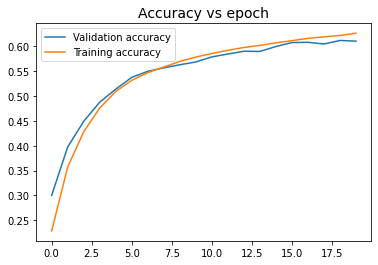

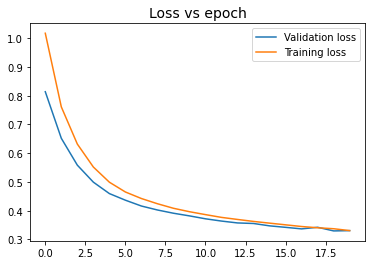

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.33075
accuracy,0.62659
val_loss,0.33064
val_accuracy,0.61068
_runtime,243
_timestamp,1620626667
_step,20
best_val_loss,0.32964
best_epoch,18
inference_val_accuracy,0.12451


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇███████
val_loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: oj8l0ewg with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 64
wandb: 	num_layers: 3


cell_RNN_ncell_64_nlayer_3_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 103s - loss: 0.8434 - accuracy: 0.3313 - val_loss: 0.6444 - val_accuracy: 0.4159
Epoch 2/20
647/647 - 98s - loss: 0.5926 - accuracy: 0.4626 - val_loss: 0.5187 - val_accuracy: 0.4864
Epoch 3/20
647/647 - 97s - loss: 0.5027 - accuracy: 0.5149 - val_loss: 0.4579 - val_accuracy: 0.5221
Epoch 4/20
647/647 - 98s - loss: 0.4475 - accuracy: 0.5483 - val_loss: 0.4197 - val_accuracy: 0.5484
Epoch 5/20
647/647 - 98s - loss: 0.4094 - accuracy: 0.5739 - val_loss: 0.3945 - val_accuracy: 0.5640
Epoch 6/20
647/647 - 98s - loss: 0.3864 - accuracy: 0.5875 - val_loss: 0.3844 - val_accuracy: 0.5714
Epoch 7/20
647/647 - 97s - loss: 0.3660 - accuracy: 0.6017 - val_loss: 0.3748 - val_accuracy: 0.5776
Epoch 8/20
647/647 - 97s - loss: 0.3517 - accuracy: 0.6113 - val_loss: 0.3543 - val_accuracy: 0.5939
Epoch 9/20
647/647 - 97s - loss: 0.3428 - accuracy: 0.6168 - val_loss: 0.3374 - val_accuracy: 0.6077
Epoch 10/20
647/647 - 95s - loss: 0.3261 - acc

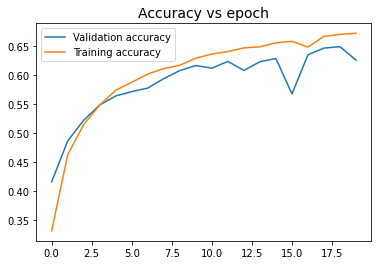

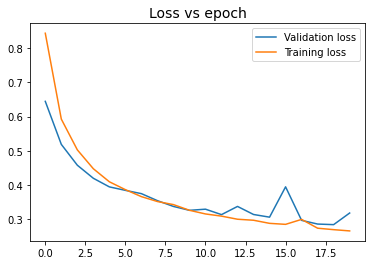

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.26588
accuracy,0.67206
val_loss,0.31818
val_accuracy,0.62562
_runtime,1944
_timestamp,1620628617
_step,20
best_val_loss,0.28423
best_epoch,18
inference_val_accuracy,0.16431


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▁▃▁▁▁▂
val_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▆███▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: k5wpwmc8 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 32
wandb: 	num_layers: 1


cell_GRU_ncell_32_nlayer_1_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 18s - loss: 1.0263 - accuracy: 0.2154 - val_loss: 0.8745 - val_accuracy: 0.2515
Epoch 2/20
647/647 - 8s - loss: 0.8805 - accuracy: 0.2753 - val_loss: 0.8207 - val_accuracy: 0.2758
Epoch 3/20
647/647 - 8s - loss: 0.8249 - accuracy: 0.3022 - val_loss: 0.7658 - val_accuracy: 0.3076
Epoch 4/20
647/647 - 8s - loss: 0.7744 - accuracy: 0.3308 - val_loss: 0.7255 - val_accuracy: 0.3380
Epoch 5/20
647/647 - 8s - loss: 0.7315 - accuracy: 0.3579 - val_loss: 0.6862 - val_accuracy: 0.3640
Epoch 6/20
647/647 - 9s - loss: 0.6915 - accuracy: 0.3820 - val_loss: 0.6441 - val_accuracy: 0.3870
Epoch 7/20
647/647 - 8s - loss: 0.6521 - accuracy: 0.4080 - val_loss: 0.6105 - val_accuracy: 0.4046
Epoch 8/20
647/647 - 8s - loss: 0.6125 - accuracy: 0.4344 - val_loss: 0.5704 - val_accuracy: 0.4406
Epoch 9/20
647/647 - 8s - loss: 0.5758 - accuracy: 0.4595 - val_loss: 0.5382 - val_accuracy: 0.4613
Epoch 10/20
647/647 - 8s - loss: 0.5429 - accuracy: 0.4

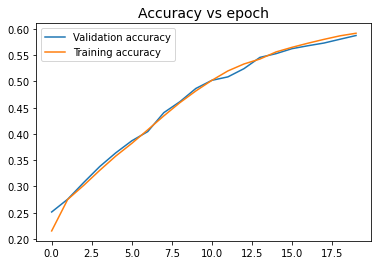

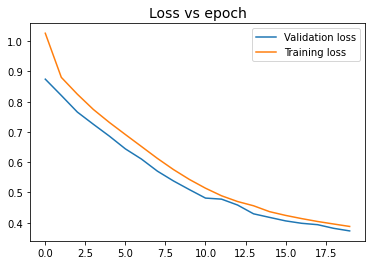

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.38768
accuracy,0.59175
val_loss,0.37293
val_accuracy,0.58742
_runtime,196
_timestamp,1620628819
_step,20
best_val_loss,0.37293
best_epoch,19
inference_val_accuracy,0.0935


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇█████
val_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: xepq6at4 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 2


cell_GRU_ncell_32_nlayer_2_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 30s - loss: 1.0376 - accuracy: 0.2076 - val_loss: 0.8879 - val_accuracy: 0.2509
Epoch 2/20
647/647 - 13s - loss: 0.8756 - accuracy: 0.2831 - val_loss: 0.7932 - val_accuracy: 0.3011
Epoch 3/20
647/647 - 13s - loss: 0.7909 - accuracy: 0.3275 - val_loss: 0.7294 - val_accuracy: 0.3344
Epoch 4/20
647/647 - 13s - loss: 0.7331 - accuracy: 0.3604 - val_loss: 0.6804 - val_accuracy: 0.3710
Epoch 5/20
647/647 - 13s - loss: 0.6850 - accuracy: 0.3934 - val_loss: 0.6358 - val_accuracy: 0.4039
Epoch 6/20
647/647 - 13s - loss: 0.6476 - accuracy: 0.4171 - val_loss: 0.6046 - val_accuracy: 0.4172
Epoch 7/20
647/647 - 13s - loss: 0.6191 - accuracy: 0.4359 - val_loss: 0.5791 - val_accuracy: 0.4379
Epoch 8/20
647/647 - 13s - loss: 0.5951 - accuracy: 0.4525 - val_loss: 0.5636 - val_accuracy: 0.4481
Epoch 9/20
647/647 - 13s - loss: 0.5773 - accuracy: 0.4637 - val_loss: 0.5393 - val_accuracy: 0.4671
Epoch 10/20
647/647 - 13s - loss: 0.5538 - accu

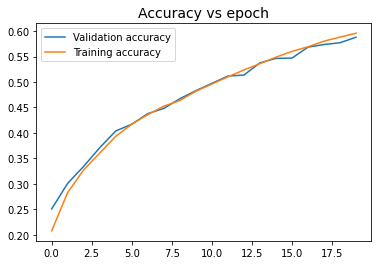

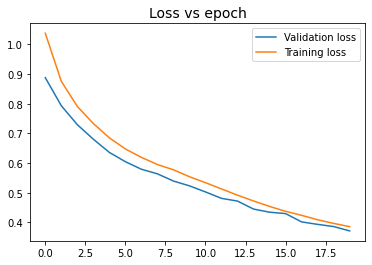

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.38556
accuracy,0.59569
val_loss,0.37123
val_accuracy,0.58789
_runtime,303
_timestamp,1620629128
_step,20
best_val_loss,0.37123
best_epoch,19
inference_val_accuracy,0.08841


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
val_loss,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: nlp7syyl with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 16
wandb: 	num_layers: 1


cell_GRU_ncell_16_nlayer_1_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 19s - loss: 1.0757 - accuracy: 0.1885 - val_loss: 0.9092 - val_accuracy: 0.2332
Epoch 2/20
647/647 - 8s - loss: 0.9191 - accuracy: 0.2601 - val_loss: 0.8590 - val_accuracy: 0.2587
Epoch 3/20
647/647 - 8s - loss: 0.8796 - accuracy: 0.2763 - val_loss: 0.8389 - val_accuracy: 0.2608
Epoch 4/20
647/647 - 8s - loss: 0.8503 - accuracy: 0.2855 - val_loss: 0.7984 - val_accuracy: 0.2844
Epoch 5/20
647/647 - 8s - loss: 0.8246 - accuracy: 0.2963 - val_loss: 0.7788 - val_accuracy: 0.2957
Epoch 6/20
647/647 - 8s - loss: 0.8056 - accuracy: 0.3077 - val_loss: 0.7627 - val_accuracy: 0.3030
Epoch 7/20
647/647 - 8s - loss: 0.7896 - accuracy: 0.3168 - val_loss: 0.7500 - val_accuracy: 0.3097
Epoch 8/20
647/647 - 8s - loss: 0.7763 - accuracy: 0.3242 - val_loss: 0.7396 - val_accuracy: 0.3152
Epoch 9/20
647/647 - 8s - loss: 0.7652 - accuracy: 0.3308 - val_loss: 0.7284 - val_accuracy: 0.3230
Epoch 10/20
647/647 - 8s - loss: 0.7550 - accuracy: 0.3

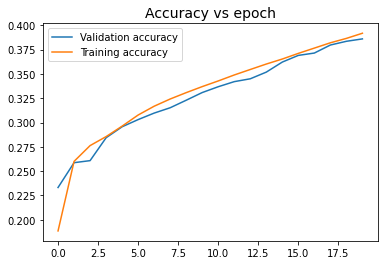

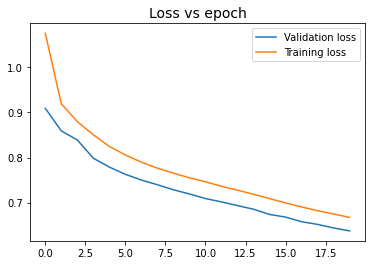

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.66719
accuracy,0.39188
val_loss,0.63718
val_accuracy,0.38606
_runtime,194
_timestamp,1620629330
_step,20
best_val_loss,0.63718
best_epoch,19
inference_val_accuracy,0.00185


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: y3fhw8fe with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 2


cell_LSTM_ncell_32_nlayer_2_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 31s - loss: 1.0826 - accuracy: 0.1962 - val_loss: 0.9281 - val_accuracy: 0.2326
Epoch 2/20
647/647 - 14s - loss: 0.9222 - accuracy: 0.2634 - val_loss: 0.8347 - val_accuracy: 0.2771
Epoch 3/20
647/647 - 14s - loss: 0.8131 - accuracy: 0.3166 - val_loss: 0.7208 - val_accuracy: 0.3473
Epoch 4/20
647/647 - 14s - loss: 0.7165 - accuracy: 0.3803 - val_loss: 0.6623 - val_accuracy: 0.3868
Epoch 5/20
647/647 - 14s - loss: 0.6516 - accuracy: 0.4277 - val_loss: 0.5945 - val_accuracy: 0.4379
Epoch 6/20
647/647 - 14s - loss: 0.6059 - accuracy: 0.4557 - val_loss: 0.5616 - val_accuracy: 0.4608
Epoch 7/20
647/647 - 14s - loss: 0.5685 - accuracy: 0.4789 - val_loss: 0.5380 - val_accuracy: 0.4702
Epoch 8/20
647/647 - 14s - loss: 0.5420 - accuracy: 0.4944 - val_loss: 0.5087 - val_accuracy: 0.4925
Epoch 9/20
647/647 - 14s - loss: 0.5107 - accuracy: 0.5148 - val_loss: 0.4780 - val_accuracy: 0.5166
Epoch 10/20
647/647 - 14s - loss: 0.4850 - acc

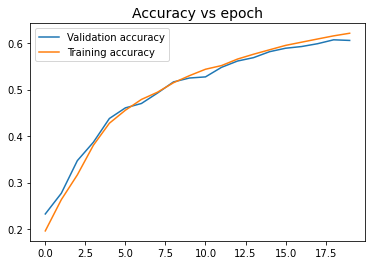

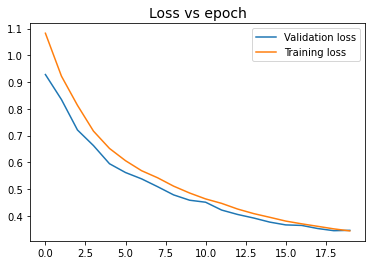

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.34317
accuracy,0.62122
val_loss,0.34528
val_accuracy,0.60577
_runtime,320
_timestamp,1620629658
_step,20
best_val_loss,0.34403
best_epoch,18
inference_val_accuracy,0.10877


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇█████
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇▇██████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: kk0ty1rv with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 64
wandb: 	num_layers: 2


cell_RNN_ncell_64_nlayer_2_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 68s - loss: 0.8864 - accuracy: 0.2967 - val_loss: 0.7079 - val_accuracy: 0.3668
Epoch 2/20
647/647 - 64s - loss: 0.6512 - accuracy: 0.4228 - val_loss: 0.5930 - val_accuracy: 0.4299
Epoch 3/20
647/647 - 62s - loss: 0.5761 - accuracy: 0.4674 - val_loss: 0.5271 - val_accuracy: 0.4789
Epoch 4/20
647/647 - 62s - loss: 0.5315 - accuracy: 0.4946 - val_loss: 0.5001 - val_accuracy: 0.4933
Epoch 5/20
647/647 - 63s - loss: 0.4981 - accuracy: 0.5142 - val_loss: 0.4761 - val_accuracy: 0.5106
Epoch 6/20
647/647 - 64s - loss: 0.4676 - accuracy: 0.5331 - val_loss: 0.4383 - val_accuracy: 0.5311
Epoch 7/20
647/647 - 63s - loss: 0.4429 - accuracy: 0.5488 - val_loss: 0.4217 - val_accuracy: 0.5441
Epoch 8/20
647/647 - 62s - loss: 0.4228 - accuracy: 0.5604 - val_loss: 0.4559 - val_accuracy: 0.5256
Epoch 9/20
647/647 - 62s - loss: 0.4124 - accuracy: 0.5675 - val_loss: 0.4158 - val_accuracy: 0.5463
Epoch 10/20
647/647 - 62s - loss: 0.4015 - accu

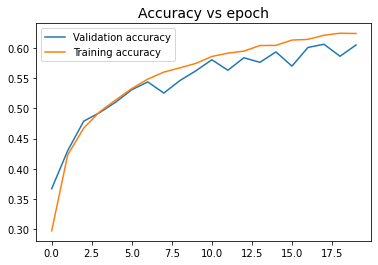

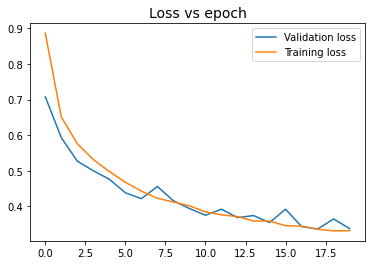

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.33174
accuracy,0.62451
val_loss,0.33748
val_accuracy,0.60542
_runtime,1277
_timestamp,1620630942
_step,20
best_val_loss,0.33634
best_epoch,17
inference_val_accuracy,0.11016


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁
val_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇█▇██▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: ujdbb5ki with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 64
wandb: 	num_layers: 1


cell_RNN_ncell_64_nlayer_1_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 35s - loss: 0.9483 - accuracy: 0.2526 - val_loss: 0.8133 - val_accuracy: 0.2876
Epoch 2/20
647/647 - 32s - loss: 0.8119 - accuracy: 0.3177 - val_loss: 0.7495 - val_accuracy: 0.3242
Epoch 3/20
647/647 - 31s - loss: 0.7571 - accuracy: 0.3470 - val_loss: 0.7111 - val_accuracy: 0.3531
Epoch 4/20
647/647 - 31s - loss: 0.7205 - accuracy: 0.3679 - val_loss: 0.6821 - val_accuracy: 0.3691
Epoch 5/20
647/647 - 32s - loss: 0.6961 - accuracy: 0.3835 - val_loss: 0.6626 - val_accuracy: 0.3831
Epoch 6/20
647/647 - 32s - loss: 0.6759 - accuracy: 0.3970 - val_loss: 0.7051 - val_accuracy: 0.3548
Epoch 7/20
647/647 - 31s - loss: 0.6617 - accuracy: 0.4049 - val_loss: 0.6560 - val_accuracy: 0.3859
Epoch 8/20
647/647 - 32s - loss: 0.6456 - accuracy: 0.4139 - val_loss: 0.6437 - val_accuracy: 0.3963
Epoch 9/20
647/647 - 32s - loss: 0.6294 - accuracy: 0.4249 - val_loss: 0.6096 - val_accuracy: 0.4154
Epoch 10/20
647/647 - 32s - loss: 0.6144 - accu

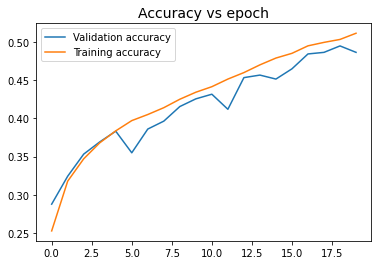

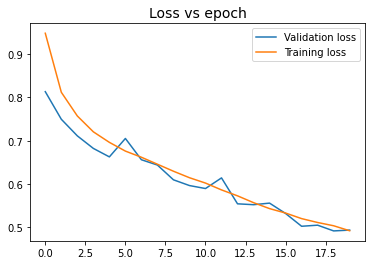

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.49181
accuracy,0.51129
val_loss,0.49334
val_accuracy,0.48629
_runtime,646
_timestamp,1620631596
_step,20
best_val_loss,0.49145
best_epoch,18
inference_val_accuracy,0.03078


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
val_loss,█▇▆▅▅▆▅▄▄▃▃▄▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▄▄▃▄▅▅▆▆▅▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 5lbmjiyu with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 64
wandb: 	num_layers: 1


cell_GRU_ncell_64_nlayer_1_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 17s - loss: 0.9874 - accuracy: 0.2306 - val_loss: 0.8604 - val_accuracy: 0.2601
Epoch 2/20
647/647 - 8s - loss: 0.8544 - accuracy: 0.2855 - val_loss: 0.7862 - val_accuracy: 0.2985
Epoch 3/20
647/647 - 8s - loss: 0.7642 - accuracy: 0.3390 - val_loss: 0.6987 - val_accuracy: 0.3549
Epoch 4/20
647/647 - 8s - loss: 0.6982 - accuracy: 0.3823 - val_loss: 0.6564 - val_accuracy: 0.3792
Epoch 5/20
647/647 - 8s - loss: 0.6382 - accuracy: 0.4229 - val_loss: 0.5855 - val_accuracy: 0.4290
Epoch 6/20
647/647 - 8s - loss: 0.5806 - accuracy: 0.4589 - val_loss: 0.5364 - val_accuracy: 0.4620
Epoch 7/20
647/647 - 8s - loss: 0.5292 - accuracy: 0.4941 - val_loss: 0.4894 - val_accuracy: 0.5064
Epoch 8/20
647/647 - 8s - loss: 0.4816 - accuracy: 0.5273 - val_loss: 0.4482 - val_accuracy: 0.5293
Epoch 9/20
647/647 - 8s - loss: 0.4396 - accuracy: 0.5564 - val_loss: 0.4136 - val_accuracy: 0.5537
Epoch 10/20
647/647 - 9s - loss: 0.4039 - accuracy: 0.5

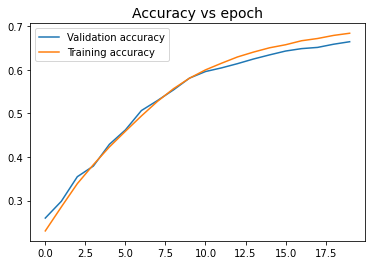

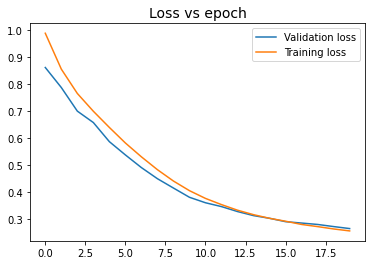

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.25466
accuracy,0.68356
val_loss,0.26337
val_accuracy,0.66414
_runtime,196
_timestamp,1620631800
_step,20
best_val_loss,0.26337
best_epoch,19
inference_val_accuracy,0.20805


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇█████
val_loss,█▇▆▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▃▄▄▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: qgr9mxtq with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 32
wandb: 	num_layers: 3


cell_GRU_ncell_32_nlayer_3_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 43s - loss: 1.0612 - accuracy: 0.2008 - val_loss: 0.8847 - val_accuracy: 0.2466
Epoch 2/20
647/647 - 18s - loss: 0.8648 - accuracy: 0.2876 - val_loss: 0.7723 - val_accuracy: 0.3110
Epoch 3/20
647/647 - 17s - loss: 0.7692 - accuracy: 0.3334 - val_loss: 0.7026 - val_accuracy: 0.3451
Epoch 4/20
647/647 - 18s - loss: 0.7036 - accuracy: 0.3772 - val_loss: 0.6485 - val_accuracy: 0.3943
Epoch 5/20
647/647 - 18s - loss: 0.6459 - accuracy: 0.4234 - val_loss: 0.5959 - val_accuracy: 0.4300
Epoch 6/20
647/647 - 18s - loss: 0.5990 - accuracy: 0.4536 - val_loss: 0.5571 - val_accuracy: 0.4577
Epoch 7/20
647/647 - 18s - loss: 0.5580 - accuracy: 0.4793 - val_loss: 0.5162 - val_accuracy: 0.4871
Epoch 8/20
647/647 - 18s - loss: 0.5247 - accuracy: 0.5017 - val_loss: 0.4955 - val_accuracy: 0.4993
Epoch 9/20
647/647 - 18s - loss: 0.4895 - accuracy: 0.5271 - val_loss: 0.4561 - val_accuracy: 0.5316
Epoch 10/20
647/647 - 18s - loss: 0.4567 - accu

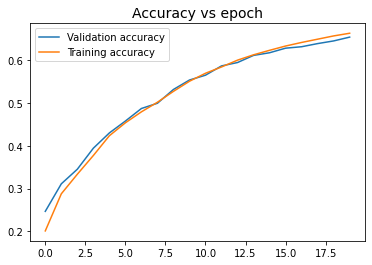

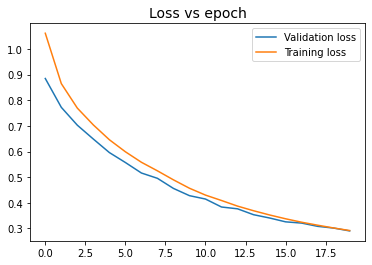

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.29178
accuracy,0.66306
val_loss,0.29032
val_accuracy,0.65399
_runtime,418
_timestamp,1620632229
_step,20
best_val_loss,0.29032
best_epoch,19
inference_val_accuracy,0.18121


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇█████
val_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 7p8plro9 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 2


cell_RNN_ncell_32_nlayer_2_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 69s - loss: 0.9755 - accuracy: 0.2462 - val_loss: 0.8226 - val_accuracy: 0.2925
Epoch 2/20
647/647 - 63s - loss: 0.7659 - accuracy: 0.3521 - val_loss: 0.7215 - val_accuracy: 0.3531
Epoch 3/20
647/647 - 64s - loss: 0.6977 - accuracy: 0.3905 - val_loss: 0.6727 - val_accuracy: 0.3795
Epoch 4/20
647/647 - 63s - loss: 0.6615 - accuracy: 0.4122 - val_loss: 0.6282 - val_accuracy: 0.4080
Epoch 5/20
647/647 - 63s - loss: 0.6315 - accuracy: 0.4272 - val_loss: 0.6464 - val_accuracy: 0.3966
Epoch 6/20
647/647 - 64s - loss: 0.6168 - accuracy: 0.4340 - val_loss: 0.5912 - val_accuracy: 0.4217
Epoch 7/20
647/647 - 63s - loss: 0.5934 - accuracy: 0.4483 - val_loss: 0.5558 - val_accuracy: 0.4536
Epoch 8/20
647/647 - 63s - loss: 0.5803 - accuracy: 0.4563 - val_loss: 0.5664 - val_accuracy: 0.4440
Epoch 9/20
647/647 - 63s - loss: 0.5679 - accuracy: 0.4640 - val_loss: 0.5595 - val_accuracy: 0.4460
Epoch 10/20
647/647 - 63s - loss: 0.5588 - accu

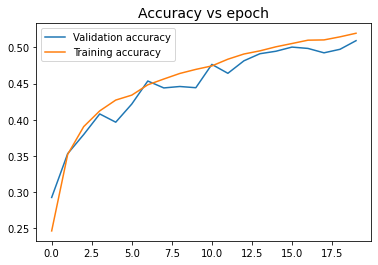

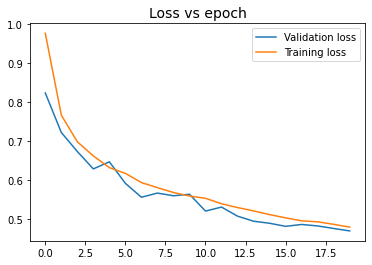

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.47922
accuracy,0.51966
val_loss,0.46952
val_accuracy,0.50937
_runtime,1277
_timestamp,1620633515
_step,20
best_val_loss,0.46952
best_epoch,19
inference_val_accuracy,0.02569


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇██████
val_loss,█▆▅▄▅▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▄▅▆▆▆▆▇▇▇▇███▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 9cfcf2sy with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 64
wandb: 	num_layers: 2


cell_GRU_ncell_64_nlayer_2_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 31s - loss: 0.9790 - accuracy: 0.2314 - val_loss: 0.8312 - val_accuracy: 0.2765
Epoch 2/20
647/647 - 14s - loss: 0.8049 - accuracy: 0.3230 - val_loss: 0.7363 - val_accuracy: 0.3333
Epoch 3/20
647/647 - 14s - loss: 0.7287 - accuracy: 0.3687 - val_loss: 0.6695 - val_accuracy: 0.3785
Epoch 4/20
647/647 - 14s - loss: 0.6652 - accuracy: 0.4122 - val_loss: 0.6148 - val_accuracy: 0.4195
Epoch 5/20
647/647 - 14s - loss: 0.6166 - accuracy: 0.4417 - val_loss: 0.5704 - val_accuracy: 0.4524
Epoch 6/20
647/647 - 13s - loss: 0.5658 - accuracy: 0.4752 - val_loss: 0.5294 - val_accuracy: 0.4779
Epoch 7/20
647/647 - 14s - loss: 0.5218 - accuracy: 0.5018 - val_loss: 0.4896 - val_accuracy: 0.5067
Epoch 8/20
647/647 - 14s - loss: 0.4828 - accuracy: 0.5279 - val_loss: 0.4606 - val_accuracy: 0.5229
Epoch 9/20
647/647 - 14s - loss: 0.4469 - accuracy: 0.5519 - val_loss: 0.4334 - val_accuracy: 0.5379
Epoch 10/20
647/647 - 14s - loss: 0.4189 - accu

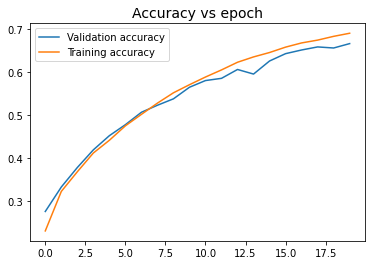

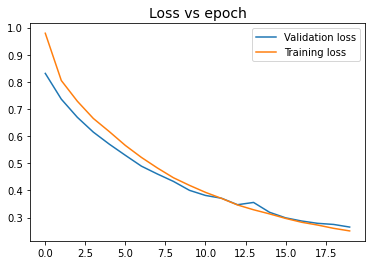

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.25113
accuracy,0.69
val_loss,0.26532
val_accuracy,0.66597
_runtime,317
_timestamp,1620633841
_step,20
best_val_loss,0.26532
best_epoch,19
inference_val_accuracy,0.20528


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇█████
val_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: pz9cw9i1 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 64
wandb: 	num_layers: 2


cell_LSTM_ncell_64_nlayer_2_emb_32_dp_0_bm_3
Epoch 1/20
647/647 - 33s - loss: 1.0100 - accuracy: 0.2291 - val_loss: 0.8237 - val_accuracy: 0.2960
Epoch 2/20
647/647 - 15s - loss: 0.7736 - accuracy: 0.3509 - val_loss: 0.6675 - val_accuracy: 0.3962
Epoch 3/20
647/647 - 14s - loss: 0.6230 - accuracy: 0.4440 - val_loss: 0.5474 - val_accuracy: 0.4680
Epoch 4/20
647/647 - 14s - loss: 0.5086 - accuracy: 0.5165 - val_loss: 0.4659 - val_accuracy: 0.5210
Epoch 5/20
647/647 - 14s - loss: 0.4335 - accuracy: 0.5648 - val_loss: 0.3914 - val_accuracy: 0.5739
Epoch 6/20
647/647 - 14s - loss: 0.3802 - accuracy: 0.5999 - val_loss: 0.3585 - val_accuracy: 0.6032
Epoch 7/20
647/647 - 14s - loss: 0.3435 - accuracy: 0.6254 - val_loss: 0.3438 - val_accuracy: 0.6069
Epoch 8/20
647/647 - 14s - loss: 0.3150 - accuracy: 0.6454 - val_loss: 0.2997 - val_accuracy: 0.6429
Epoch 9/20
647/647 - 14s - loss: 0.2882 - accuracy: 0.6655 - val_loss: 0.2818 - val_accuracy: 0.6561
Epoch 10/20
647/647 - 14s - loss: 0.2676 - acc

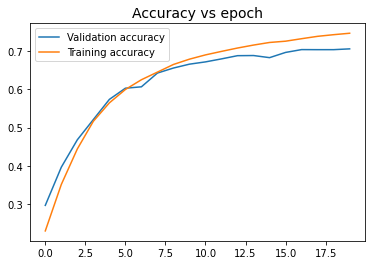

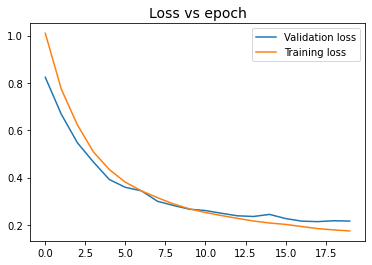

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.17426
accuracy,0.74732
val_loss,0.21587
val_accuracy,0.70637
_runtime,332
_timestamp,1620634182
_step,20
best_val_loss,0.21351
best_epoch,17
inference_val_accuracy,0.27308


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇█████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: cm8og8e2 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 32
wandb: 	num_layers: 3


cell_LSTM_ncell_32_nlayer_3_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 47s - loss: 1.1043 - accuracy: 0.1887 - val_loss: 0.9854 - val_accuracy: 0.2164
Epoch 2/20
647/647 - 20s - loss: 0.9324 - accuracy: 0.2716 - val_loss: 0.8020 - val_accuracy: 0.3125
Epoch 3/20
647/647 - 19s - loss: 0.7889 - accuracy: 0.3484 - val_loss: 0.7103 - val_accuracy: 0.3728
Epoch 4/20
647/647 - 19s - loss: 0.7025 - accuracy: 0.3991 - val_loss: 0.6437 - val_accuracy: 0.4164
Epoch 5/20
647/647 - 20s - loss: 0.6367 - accuracy: 0.4455 - val_loss: 0.5752 - val_accuracy: 0.4672
Epoch 6/20
647/647 - 20s - loss: 0.5800 - accuracy: 0.4852 - val_loss: 0.5299 - val_accuracy: 0.5017
Epoch 7/20
647/647 - 19s - loss: 0.5340 - accuracy: 0.5156 - val_loss: 0.4980 - val_accuracy: 0.5216
Epoch 8/20
647/647 - 19s - loss: 0.4957 - accuracy: 0.5408 - val_loss: 0.5294 - val_accuracy: 0.4961
Epoch 9/20
647/647 - 19s - loss: 0.4713 - accuracy: 0.5566 - val_loss: 0.4384 - val_accuracy: 0.5620
Epoch 10/20
647/647 - 19s - loss: 0.4406 - acc

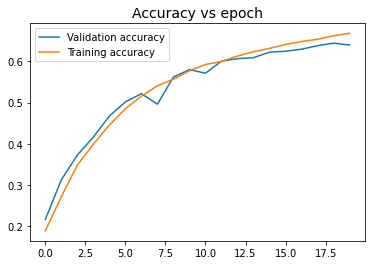

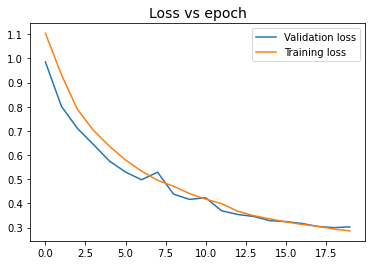

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.28632
accuracy,0.66815
val_loss,0.30303
val_accuracy,0.63946
_runtime,453
_timestamp,1620634648
_step,20
best_val_loss,0.29995
best_epoch,18
inference_val_accuracy,0.1576


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇█████
val_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 8byuad5b with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 1


cell_GRU_ncell_32_nlayer_1_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 17s - loss: 1.0241 - accuracy: 0.2157 - val_loss: 0.8737 - val_accuracy: 0.2476
Epoch 2/20
647/647 - 8s - loss: 0.8829 - accuracy: 0.2737 - val_loss: 0.8262 - val_accuracy: 0.2707
Epoch 3/20
647/647 - 8s - loss: 0.8364 - accuracy: 0.2955 - val_loss: 0.7811 - val_accuracy: 0.2941
Epoch 4/20
647/647 - 8s - loss: 0.8003 - accuracy: 0.3110 - val_loss: 0.7611 - val_accuracy: 0.3040
Epoch 5/20
647/647 - 9s - loss: 0.7737 - accuracy: 0.3251 - val_loss: 0.7307 - val_accuracy: 0.3224
Epoch 6/20
647/647 - 8s - loss: 0.7547 - accuracy: 0.3357 - val_loss: 0.7320 - val_accuracy: 0.3253
Epoch 7/20
647/647 - 8s - loss: 0.7424 - accuracy: 0.3446 - val_loss: 0.7084 - val_accuracy: 0.3443
Epoch 8/20
647/647 - 8s - loss: 0.7260 - accuracy: 0.3580 - val_loss: 0.6987 - val_accuracy: 0.3476
Epoch 9/20
647/647 - 8s - loss: 0.7111 - accuracy: 0.3688 - val_loss: 0.6891 - val_accuracy: 0.3565
Epoch 10/20
647/647 - 8s - loss: 0.6954 - accuracy: 0.3

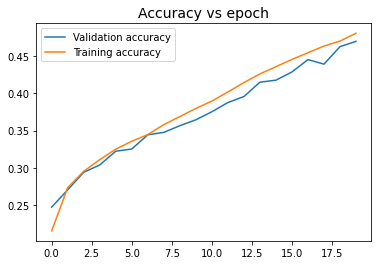

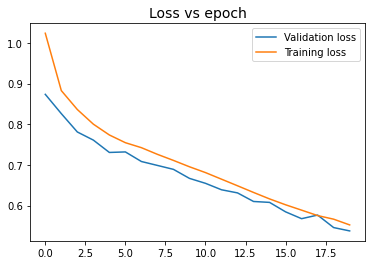

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.55233
accuracy,0.48028
val_loss,0.53755
val_accuracy,0.46946
_runtime,199
_timestamp,1620634856
_step,20
best_val_loss,0.53755
best_epoch,19
inference_val_accuracy,0.0118


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
accuracy,▁▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇███
val_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
val_accuracy,▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: arz50t4t with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 64
wandb: 	num_layers: 1


cell_GRU_ncell_64_nlayer_1_emb_32_dp_0_bm_3
Epoch 1/20
647/647 - 18s - loss: 0.9890 - accuracy: 0.2290 - val_loss: 0.8731 - val_accuracy: 0.2438
Epoch 2/20
647/647 - 9s - loss: 0.8445 - accuracy: 0.2941 - val_loss: 0.7609 - val_accuracy: 0.3130
Epoch 3/20
647/647 - 9s - loss: 0.7461 - accuracy: 0.3495 - val_loss: 0.7096 - val_accuracy: 0.3462
Epoch 4/20
647/647 - 9s - loss: 0.6733 - accuracy: 0.3961 - val_loss: 0.6142 - val_accuracy: 0.4139
Epoch 5/20
647/647 - 9s - loss: 0.6042 - accuracy: 0.4469 - val_loss: 0.5518 - val_accuracy: 0.4591
Epoch 6/20
647/647 - 8s - loss: 0.5408 - accuracy: 0.4877 - val_loss: 0.4946 - val_accuracy: 0.5013
Epoch 7/20
647/647 - 9s - loss: 0.4859 - accuracy: 0.5239 - val_loss: 0.4445 - val_accuracy: 0.5335
Epoch 8/20
647/647 - 9s - loss: 0.4399 - accuracy: 0.5549 - val_loss: 0.4148 - val_accuracy: 0.5550
Epoch 9/20
647/647 - 9s - loss: 0.4049 - accuracy: 0.5784 - val_loss: 0.3797 - val_accuracy: 0.5804
Epoch 10/20
647/647 - 9s - loss: 0.3742 - accuracy: 0.5

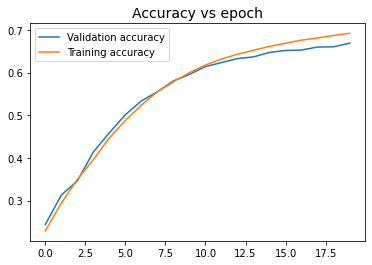

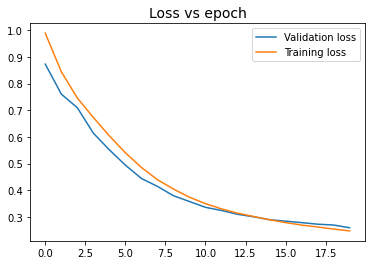

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.24784
accuracy,0.69209
val_loss,0.25967
val_accuracy,0.66893
_runtime,200
_timestamp,1620635074
_step,20
best_val_loss,0.25967
best_epoch,19
inference_val_accuracy,0.21384


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▇▇▇▇▇██████
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇▇██████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: fqpv8cjb with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 3


cell_LSTM_ncell_32_nlayer_3_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 45s - loss: 1.1065 - accuracy: 0.1922 - val_loss: 0.9663 - val_accuracy: 0.2334
Epoch 2/20
647/647 - 19s - loss: 0.9418 - accuracy: 0.2630 - val_loss: 0.8750 - val_accuracy: 0.2647
Epoch 3/20
647/647 - 19s - loss: 0.8575 - accuracy: 0.2974 - val_loss: 0.7800 - val_accuracy: 0.3207
Epoch 4/20
647/647 - 19s - loss: 0.7926 - accuracy: 0.3388 - val_loss: 0.7385 - val_accuracy: 0.3524
Epoch 5/20
647/647 - 19s - loss: 0.7366 - accuracy: 0.3829 - val_loss: 0.6864 - val_accuracy: 0.3887
Epoch 6/20
647/647 - 19s - loss: 0.6845 - accuracy: 0.4114 - val_loss: 0.6284 - val_accuracy: 0.4193
Epoch 7/20
647/647 - 19s - loss: 0.6390 - accuracy: 0.4360 - val_loss: 0.6274 - val_accuracy: 0.4123
Epoch 8/20
647/647 - 19s - loss: 0.6038 - accuracy: 0.4567 - val_loss: 0.5581 - val_accuracy: 0.4638
Epoch 9/20
647/647 - 19s - loss: 0.5644 - accuracy: 0.4825 - val_loss: 0.5236 - val_accuracy: 0.4847
Epoch 10/20
647/647 - 19s - loss: 0.5344 - acc

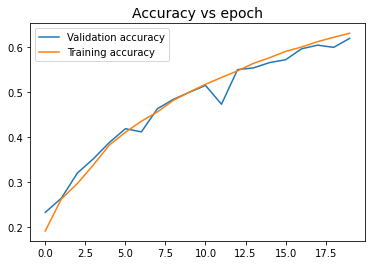

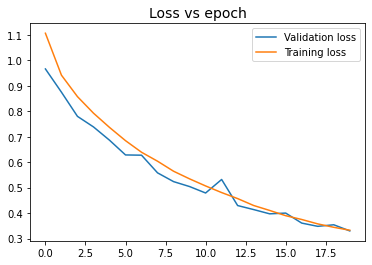

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.33266
accuracy,0.63151
val_loss,0.32996
val_accuracy,0.62016
_runtime,440
_timestamp,1620635522
_step,20
best_val_loss,0.32996
best_epoch,19
inference_val_accuracy,0.13307


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇████
val_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▃▄▄▄▅▆▆▆▅▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 90tkpdb9 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 16
wandb: 	num_layers: 3


cell_GRU_ncell_16_nlayer_3_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 42s - loss: 1.0981 - accuracy: 0.1881 - val_loss: 0.9427 - val_accuracy: 0.2123
Epoch 2/20
647/647 - 17s - loss: 0.9522 - accuracy: 0.2382 - val_loss: 0.8847 - val_accuracy: 0.2527
Epoch 3/20
647/647 - 17s - loss: 0.9064 - accuracy: 0.2617 - val_loss: 0.8858 - val_accuracy: 0.2402
Epoch 4/20
647/647 - 17s - loss: 0.8842 - accuracy: 0.2717 - val_loss: 0.8328 - val_accuracy: 0.2684
Epoch 5/20
647/647 - 17s - loss: 0.8645 - accuracy: 0.2801 - val_loss: 0.8211 - val_accuracy: 0.2726
Epoch 6/20
647/647 - 18s - loss: 0.8425 - accuracy: 0.2906 - val_loss: 0.7888 - val_accuracy: 0.2911
Epoch 7/20
647/647 - 18s - loss: 0.8148 - accuracy: 0.3054 - val_loss: 0.7612 - val_accuracy: 0.3075
Epoch 8/20
647/647 - 18s - loss: 0.7818 - accuracy: 0.3240 - val_loss: 0.7436 - val_accuracy: 0.3188
Epoch 9/20
647/647 - 17s - loss: 0.7555 - accuracy: 0.3417 - val_loss: 0.7134 - val_accuracy: 0.3391
Epoch 10/20
647/647 - 18s - loss: 0.7360 - accu

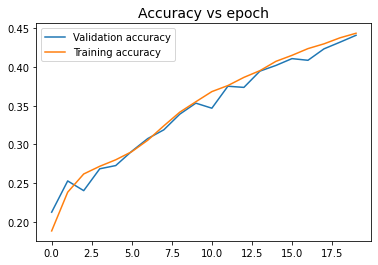

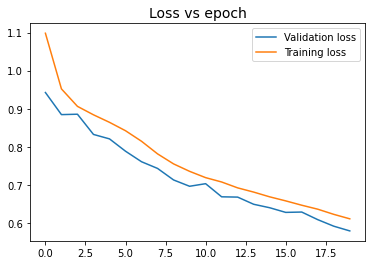

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.61152
accuracy,0.44375
val_loss,0.5798
val_accuracy,0.44109
_runtime,413
_timestamp,1620635945
_step,20
best_val_loss,0.5798
best_epoch,19
inference_val_accuracy,0.00879


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
accuracy,▁▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
val_loss,█▇▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁
val_accuracy,▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: ep1h55fz with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 16
wandb: 	num_layers: 2


cell_GRU_ncell_16_nlayer_2_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 30s - loss: 1.1103 - accuracy: 0.1849 - val_loss: 0.9431 - val_accuracy: 0.2139
Epoch 2/20
647/647 - 13s - loss: 0.9374 - accuracy: 0.2430 - val_loss: 0.8749 - val_accuracy: 0.2420
Epoch 3/20
647/647 - 13s - loss: 0.8897 - accuracy: 0.2661 - val_loss: 0.8362 - val_accuracy: 0.2709
Epoch 4/20
647/647 - 13s - loss: 0.8571 - accuracy: 0.2854 - val_loss: 0.8121 - val_accuracy: 0.2890
Epoch 5/20
647/647 - 13s - loss: 0.8291 - accuracy: 0.3015 - val_loss: 0.7779 - val_accuracy: 0.3019
Epoch 6/20
647/647 - 13s - loss: 0.8022 - accuracy: 0.3131 - val_loss: 0.7531 - val_accuracy: 0.3139
Epoch 7/20
647/647 - 13s - loss: 0.7761 - accuracy: 0.3255 - val_loss: 0.7316 - val_accuracy: 0.3204
Epoch 8/20
647/647 - 13s - loss: 0.7551 - accuracy: 0.3393 - val_loss: 0.7155 - val_accuracy: 0.3375
Epoch 9/20
647/647 - 13s - loss: 0.7367 - accuracy: 0.3530 - val_loss: 0.6957 - val_accuracy: 0.3510
Epoch 10/20
647/647 - 13s - loss: 0.7189 - accu

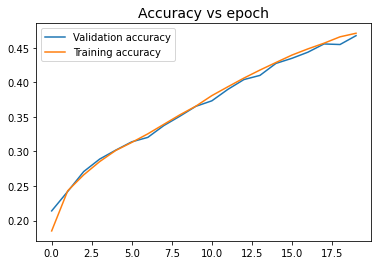

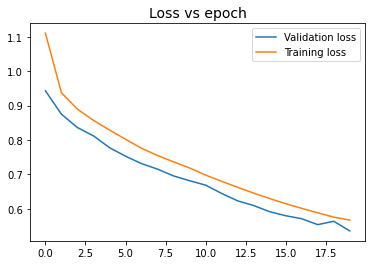

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.56738
accuracy,0.4712
val_loss,0.53601
val_accuracy,0.46769
_runtime,306
_timestamp,1620636260
_step,20
best_val_loss,0.53601
best_epoch,19
inference_val_accuracy,0.01689


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇███
val_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: z5q8atxh with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 16
wandb: 	num_layers: 2


cell_LSTM_ncell_16_nlayer_2_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 33s - loss: 1.1224 - accuracy: 0.1738 - val_loss: 0.9694 - val_accuracy: 0.2231
Epoch 2/20
647/647 - 13s - loss: 0.9423 - accuracy: 0.2600 - val_loss: 0.8455 - val_accuracy: 0.2814
Epoch 3/20
647/647 - 14s - loss: 0.8440 - accuracy: 0.3081 - val_loss: 0.7731 - val_accuracy: 0.3305
Epoch 4/20
647/647 - 14s - loss: 0.7757 - accuracy: 0.3487 - val_loss: 0.7154 - val_accuracy: 0.3612
Epoch 5/20
647/647 - 13s - loss: 0.7208 - accuracy: 0.3785 - val_loss: 0.6693 - val_accuracy: 0.3911
Epoch 6/20
647/647 - 14s - loss: 0.6799 - accuracy: 0.4025 - val_loss: 0.6328 - val_accuracy: 0.4110
Epoch 7/20
647/647 - 14s - loss: 0.6488 - accuracy: 0.4207 - val_loss: 0.6114 - val_accuracy: 0.4241
Epoch 8/20
647/647 - 14s - loss: 0.6252 - accuracy: 0.4332 - val_loss: 0.5880 - val_accuracy: 0.4322
Epoch 9/20
647/647 - 14s - loss: 0.6059 - accuracy: 0.4440 - val_loss: 0.5746 - val_accuracy: 0.4450
Epoch 10/20
647/647 - 14s - loss: 0.5904 - acc

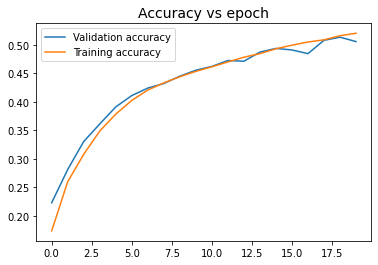

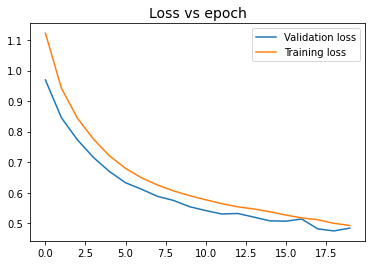

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.49272
accuracy,0.52027
val_loss,0.48398
val_accuracy,0.50565
_runtime,319
_timestamp,1620636587
_step,20
best_val_loss,0.47485
best_epoch,18
inference_val_accuracy,0.03124


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁
val_accuracy,▁▂▄▄▅▆▆▆▆▇▇▇▇▇█▇▇███
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: jhemkiwl with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 32
wandb: 	num_layers: 1


cell_LSTM_ncell_32_nlayer_1_emb_32_dp_0_bm_3
Epoch 1/20
647/647 - 19s - loss: 1.0343 - accuracy: 0.2176 - val_loss: 0.8556 - val_accuracy: 0.2703
Epoch 2/20
647/647 - 8s - loss: 0.8212 - accuracy: 0.3186 - val_loss: 0.7180 - val_accuracy: 0.3474
Epoch 3/20
647/647 - 9s - loss: 0.7029 - accuracy: 0.3786 - val_loss: 0.6333 - val_accuracy: 0.3997
Epoch 4/20
647/647 - 9s - loss: 0.6345 - accuracy: 0.4195 - val_loss: 0.5785 - val_accuracy: 0.4300
Epoch 5/20
647/647 - 9s - loss: 0.5833 - accuracy: 0.4531 - val_loss: 0.5363 - val_accuracy: 0.4605
Epoch 6/20
647/647 - 9s - loss: 0.5454 - accuracy: 0.4789 - val_loss: 0.5095 - val_accuracy: 0.4756
Epoch 7/20
647/647 - 9s - loss: 0.5168 - accuracy: 0.4973 - val_loss: 0.4815 - val_accuracy: 0.5030
Epoch 8/20
647/647 - 9s - loss: 0.4915 - accuracy: 0.5151 - val_loss: 0.4587 - val_accuracy: 0.5180
Epoch 9/20
647/647 - 9s - loss: 0.4717 - accuracy: 0.5275 - val_loss: 0.4639 - val_accuracy: 0.5070
Epoch 10/20
647/647 - 8s - loss: 0.4582 - accuracy: 0.

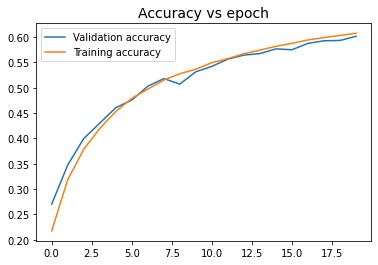

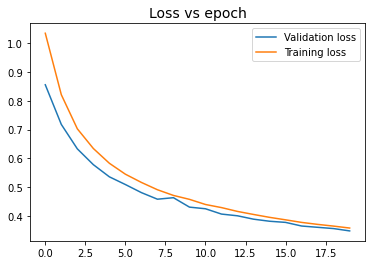

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.35864
accuracy,0.60732
val_loss,0.34866
val_accuracy,0.60129
_runtime,201
_timestamp,1620636797
_step,20
best_val_loss,0.34866
best_epoch,19
inference_val_accuracy,0.10831


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇██████
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: usqpixss with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 16
wandb: 	num_layers: 3


cell_LSTM_ncell_16_nlayer_3_emb_64_dp_0_bm_3
Epoch 1/20
647/647 - 44s - loss: 1.1273 - accuracy: 0.1786 - val_loss: 1.0076 - val_accuracy: 0.2083
Epoch 2/20
647/647 - 19s - loss: 1.0107 - accuracy: 0.2421 - val_loss: 0.9029 - val_accuracy: 0.2733
Epoch 3/20
647/647 - 19s - loss: 0.8920 - accuracy: 0.2985 - val_loss: 0.8086 - val_accuracy: 0.3150
Epoch 4/20
647/647 - 19s - loss: 0.8131 - accuracy: 0.3333 - val_loss: 0.7384 - val_accuracy: 0.3490
Epoch 5/20
647/647 - 19s - loss: 0.7460 - accuracy: 0.3647 - val_loss: 0.6817 - val_accuracy: 0.3753
Epoch 6/20
647/647 - 20s - loss: 0.6968 - accuracy: 0.3890 - val_loss: 0.6476 - val_accuracy: 0.3930
Epoch 7/20
647/647 - 20s - loss: 0.6570 - accuracy: 0.4124 - val_loss: 0.6194 - val_accuracy: 0.4097
Epoch 8/20
647/647 - 19s - loss: 0.6208 - accuracy: 0.4354 - val_loss: 0.5769 - val_accuracy: 0.4411
Epoch 9/20
647/647 - 19s - loss: 0.5878 - accuracy: 0.4565 - val_loss: 0.5453 - val_accuracy: 0.4641
Epoch 10/20
647/647 - 19s - loss: 0.5620 - acc

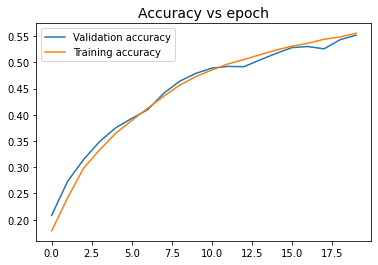

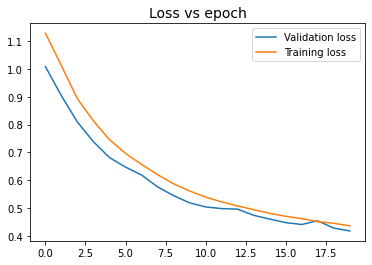

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.43712
accuracy,0.55537
val_loss,0.41894
val_accuracy,0.55161
_runtime,447
_timestamp,1620637262
_step,20
best_val_loss,0.41894
best_epoch,19
inference_val_accuracy,0.05485


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇█████
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▆▆▇▇▇▇▇▇██▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2w3xhar with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 16
wandb: 	num_layers: 1


cell_LSTM_ncell_16_nlayer_1_emb_64_dp_0_bm_3
Epoch 1/20
647/647 - 18s - loss: 1.0846 - accuracy: 0.1944 - val_loss: 0.8825 - val_accuracy: 0.2602
Epoch 2/20
647/647 - 9s - loss: 0.8516 - accuracy: 0.2997 - val_loss: 0.7580 - val_accuracy: 0.3226
Epoch 3/20
647/647 - 9s - loss: 0.7526 - accuracy: 0.3526 - val_loss: 0.6813 - val_accuracy: 0.3627
Epoch 4/20
647/647 - 9s - loss: 0.6848 - accuracy: 0.3901 - val_loss: 0.6283 - val_accuracy: 0.3951
Epoch 5/20
647/647 - 9s - loss: 0.6382 - accuracy: 0.4178 - val_loss: 0.5946 - val_accuracy: 0.4168
Epoch 6/20
647/647 - 9s - loss: 0.6052 - accuracy: 0.4381 - val_loss: 0.5628 - val_accuracy: 0.4437
Epoch 7/20
647/647 - 9s - loss: 0.5790 - accuracy: 0.4547 - val_loss: 0.5426 - val_accuracy: 0.4542
Epoch 8/20
647/647 - 9s - loss: 0.5591 - accuracy: 0.4664 - val_loss: 0.5248 - val_accuracy: 0.4640
Epoch 9/20
647/647 - 9s - loss: 0.5421 - accuracy: 0.4780 - val_loss: 0.5143 - val_accuracy: 0.4761
Epoch 10/20
647/647 - 9s - loss: 0.5293 - accuracy: 0.

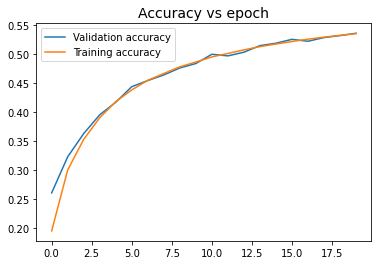

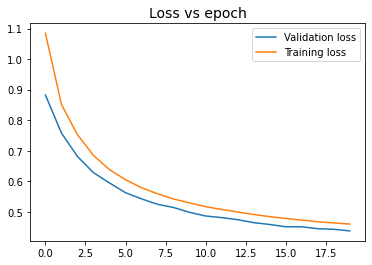

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.46008
accuracy,0.53532
val_loss,0.43766
val_accuracy,0.53603
_runtime,203
_timestamp,1620637483
_step,20
best_val_loss,0.43766
best_epoch,19
inference_val_accuracy,0.05647


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: p316ch9v with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 16
wandb: 	num_layers: 1


cell_GRU_ncell_16_nlayer_1_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 18s - loss: 1.0762 - accuracy: 0.1914 - val_loss: 0.8940 - val_accuracy: 0.2465
Epoch 2/20
647/647 - 9s - loss: 0.8859 - accuracy: 0.2736 - val_loss: 0.8069 - val_accuracy: 0.2837
Epoch 3/20
647/647 - 9s - loss: 0.8164 - accuracy: 0.3036 - val_loss: 0.7582 - val_accuracy: 0.3058
Epoch 4/20
647/647 - 9s - loss: 0.7733 - accuracy: 0.3225 - val_loss: 0.7212 - val_accuracy: 0.3260
Epoch 5/20
647/647 - 8s - loss: 0.7419 - accuracy: 0.3378 - val_loss: 0.6960 - val_accuracy: 0.3408
Epoch 6/20
647/647 - 9s - loss: 0.7191 - accuracy: 0.3502 - val_loss: 0.6773 - val_accuracy: 0.3511
Epoch 7/20
647/647 - 9s - loss: 0.7007 - accuracy: 0.3614 - val_loss: 0.6647 - val_accuracy: 0.3617
Epoch 8/20
647/647 - 8s - loss: 0.6843 - accuracy: 0.3720 - val_loss: 0.6480 - val_accuracy: 0.3723
Epoch 9/20
647/647 - 8s - loss: 0.6680 - accuracy: 0.3833 - val_loss: 0.6322 - val_accuracy: 0.3789
Epoch 10/20
647/647 - 8s - loss: 0.6522 - accuracy: 0.3

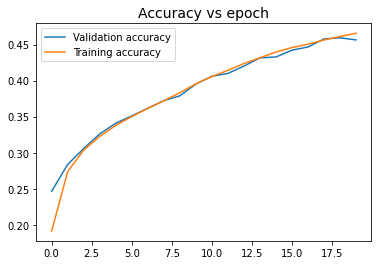

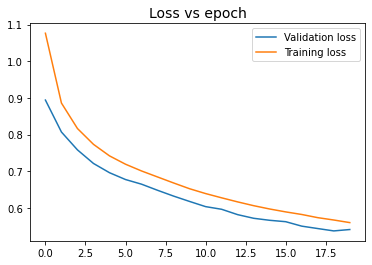

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.5599
accuracy,0.46578
val_loss,0.54103
val_accuracy,0.45653
_runtime,203
_timestamp,1620637695
_step,20
best_val_loss,0.53723
best_epoch,18
inference_val_accuracy,0.01296


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇████
val_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzj8t9c4 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 16
wandb: 	num_layers: 3


cell_LSTM_ncell_16_nlayer_3_emb_64_dp_0_bm_3
Epoch 1/20
647/647 - 45s - loss: 1.1349 - accuracy: 0.1790 - val_loss: 1.0126 - val_accuracy: 0.2041
Epoch 2/20
647/647 - 19s - loss: 1.0365 - accuracy: 0.2163 - val_loss: 0.9617 - val_accuracy: 0.2319
Epoch 3/20
647/647 - 19s - loss: 0.9574 - accuracy: 0.2714 - val_loss: 0.8627 - val_accuracy: 0.2948
Epoch 4/20
647/647 - 19s - loss: 0.8634 - accuracy: 0.3187 - val_loss: 0.7949 - val_accuracy: 0.3297
Epoch 5/20
647/647 - 19s - loss: 0.8036 - accuracy: 0.3491 - val_loss: 0.7442 - val_accuracy: 0.3603
Epoch 6/20
647/647 - 19s - loss: 0.7553 - accuracy: 0.3772 - val_loss: 0.7018 - val_accuracy: 0.3824
Epoch 7/20
647/647 - 19s - loss: 0.7160 - accuracy: 0.3995 - val_loss: 0.6721 - val_accuracy: 0.4000
Epoch 8/20
647/647 - 19s - loss: 0.6852 - accuracy: 0.4181 - val_loss: 0.6837 - val_accuracy: 0.3968
Epoch 9/20
647/647 - 19s - loss: 0.6613 - accuracy: 0.4338 - val_loss: 0.6287 - val_accuracy: 0.4276
Epoch 10/20
647/647 - 20s - loss: 0.6369 - acc

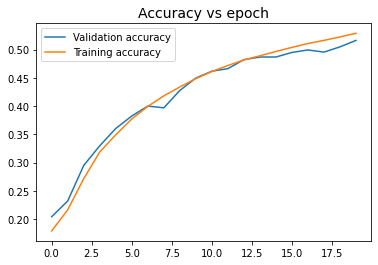

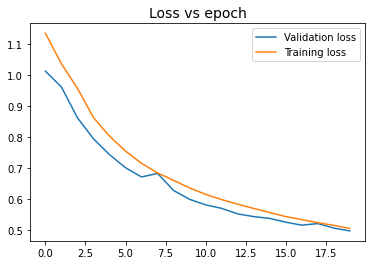

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.50652
accuracy,0.5289
val_loss,0.49843
val_accuracy,0.51621
_runtime,446
_timestamp,1620638159
_step,20
best_val_loss,0.49843
best_epoch,19
inference_val_accuracy,0.03333


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇█████
val_loss,█▇▆▅▄▄▃▄▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▅▅▆▇▇▇▇▇▇█████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: r6x4nu9l with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 64
wandb: 	num_layers: 3


cell_LSTM_ncell_64_nlayer_3_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 44s - loss: 1.0651 - accuracy: 0.2092 - val_loss: 0.8936 - val_accuracy: 0.2736
Epoch 2/20
647/647 - 20s - loss: 0.7600 - accuracy: 0.3648 - val_loss: 0.6555 - val_accuracy: 0.4038
Epoch 3/20
647/647 - 19s - loss: 0.5836 - accuracy: 0.4711 - val_loss: 0.5082 - val_accuracy: 0.4994
Epoch 4/20
647/647 - 20s - loss: 0.4787 - accuracy: 0.5402 - val_loss: 0.4292 - val_accuracy: 0.5550
Epoch 5/20
647/647 - 19s - loss: 0.4012 - accuracy: 0.5897 - val_loss: 0.3626 - val_accuracy: 0.6026
Epoch 6/20
647/647 - 18s - loss: 0.3462 - accuracy: 0.6277 - val_loss: 0.3209 - val_accuracy: 0.6320
Epoch 7/20
647/647 - 19s - loss: 0.3063 - accuracy: 0.6561 - val_loss: 0.3024 - val_accuracy: 0.6486
Epoch 8/20
647/647 - 19s - loss: 0.2777 - accuracy: 0.6774 - val_loss: 0.2770 - val_accuracy: 0.6653
Epoch 9/20
647/647 - 20s - loss: 0.2555 - accuracy: 0.6925 - val_loss: 0.2569 - val_accuracy: 0.6797
Epoch 10/20
647/647 - 20s - loss: 0.2364 - acc

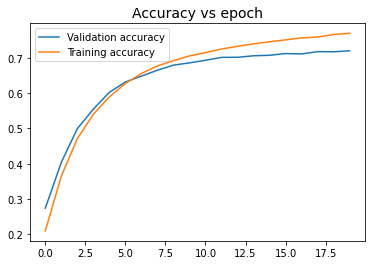

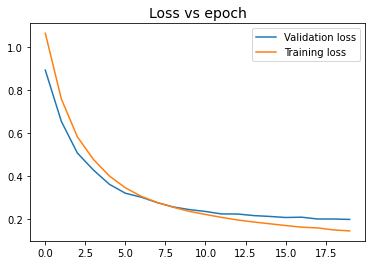

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.14571
accuracy,0.77022
val_loss,0.19918
val_accuracy,0.72042
_runtime,452
_timestamp,1620638620
_step,20
best_val_loss,0.19918
best_epoch,19
inference_val_accuracy,0.30664


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇▇▇██████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: wprql34j with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 16
wandb: 	num_layers: 3


cell_GRU_ncell_16_nlayer_3_emb_64_dp_0_bm_3
Epoch 1/20
647/647 - 45s - loss: 1.1280 - accuracy: 0.1695 - val_loss: 0.9808 - val_accuracy: 0.2114
Epoch 2/20
647/647 - 18s - loss: 0.9847 - accuracy: 0.2349 - val_loss: 0.8953 - val_accuracy: 0.2660
Epoch 3/20
647/647 - 18s - loss: 0.8848 - accuracy: 0.3025 - val_loss: 0.8127 - val_accuracy: 0.3143
Epoch 4/20
647/647 - 18s - loss: 0.8309 - accuracy: 0.3286 - val_loss: 0.8147 - val_accuracy: 0.3070
Epoch 5/20
647/647 - 18s - loss: 0.8013 - accuracy: 0.3405 - val_loss: 0.7491 - val_accuracy: 0.3409
Epoch 6/20
647/647 - 18s - loss: 0.7773 - accuracy: 0.3484 - val_loss: 0.7271 - val_accuracy: 0.3498
Epoch 7/20
647/647 - 19s - loss: 0.7576 - accuracy: 0.3529 - val_loss: 0.7099 - val_accuracy: 0.3520
Epoch 8/20
647/647 - 18s - loss: 0.7410 - accuracy: 0.3577 - val_loss: 0.7005 - val_accuracy: 0.3476
Epoch 9/20
647/647 - 18s - loss: 0.7284 - accuracy: 0.3612 - val_loss: 0.6835 - val_accuracy: 0.3592
Epoch 10/20
647/647 - 18s - loss: 0.7162 - accu

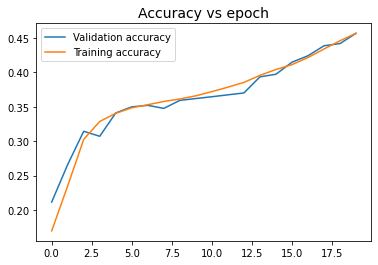

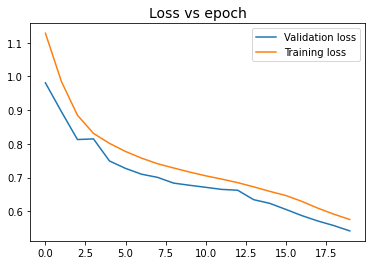

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.57549
accuracy,0.4568
val_loss,0.54166
val_accuracy,0.4567
_runtime,428
_timestamp,1620639056
_step,20
best_val_loss,0.54166
best_epoch,19
inference_val_accuracy,0.01481


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
val_loss,█▇▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: iqa2kl4y with config:
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 3


cell_RNN_ncell_32_nlayer_3_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 103s - loss: 0.9645 - accuracy: 0.2488 - val_loss: 0.8031 - val_accuracy: 0.2967
Epoch 2/20
647/647 - 96s - loss: 0.7878 - accuracy: 0.3355 - val_loss: 0.7093 - val_accuracy: 0.3579
Epoch 3/20
647/647 - 97s - loss: 0.7105 - accuracy: 0.3816 - val_loss: 0.6545 - val_accuracy: 0.3934
Epoch 4/20
647/647 - 96s - loss: 0.6669 - accuracy: 0.4079 - val_loss: 0.6200 - val_accuracy: 0.4114
Epoch 5/20
647/647 - 96s - loss: 0.6337 - accuracy: 0.4269 - val_loss: 0.6147 - val_accuracy: 0.4238
Epoch 6/20
647/647 - 96s - loss: 0.6104 - accuracy: 0.4400 - val_loss: 0.5623 - val_accuracy: 0.4539
Epoch 7/20
647/647 - 95s - loss: 0.5783 - accuracy: 0.4606 - val_loss: 0.5625 - val_accuracy: 0.4504
Epoch 8/20
647/647 - 96s - loss: 0.5569 - accuracy: 0.4743 - val_loss: 0.5286 - val_accuracy: 0.4728
Epoch 9/20
647/647 - 95s - loss: 0.5446 - accuracy: 0.4816 - val_loss: 0.5182 - val_accuracy: 0.4762
Epoch 10/20
647/647 - 95s - loss: 0.5256 - acc

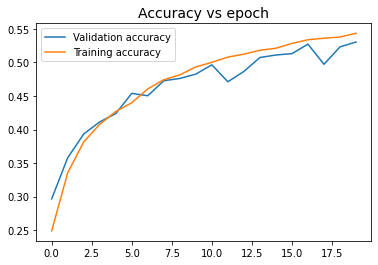

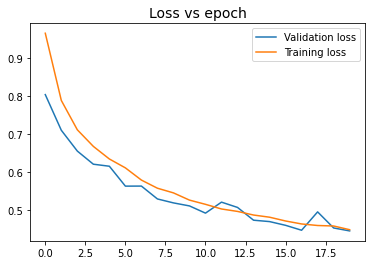

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.44772
accuracy,0.5436
val_loss,0.44452
val_accuracy,0.53057
_runtime,1939
_timestamp,1620641006
_step,20
best_val_loss,0.44452
best_epoch,19
inference_val_accuracy,0.0486


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁
val_accuracy,▁▃▄▄▅▆▆▆▆▇▇▆▇▇▇▇█▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: zldo887n with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 64
wandb: 	num_layers: 3


cell_GRU_ncell_64_nlayer_3_emb_32_dp_0_bm_1
Epoch 1/20
647/647 - 43s - loss: 0.9855 - accuracy: 0.2285 - val_loss: 0.8443 - val_accuracy: 0.2683
Epoch 2/20
647/647 - 19s - loss: 0.7989 - accuracy: 0.3276 - val_loss: 0.7011 - val_accuracy: 0.3605
Epoch 3/20
647/647 - 19s - loss: 0.6848 - accuracy: 0.4017 - val_loss: 0.6205 - val_accuracy: 0.4162
Epoch 4/20
647/647 - 18s - loss: 0.5865 - accuracy: 0.4651 - val_loss: 0.5275 - val_accuracy: 0.4797
Epoch 5/20
647/647 - 18s - loss: 0.4969 - accuracy: 0.5238 - val_loss: 0.4387 - val_accuracy: 0.5435
Epoch 6/20
647/647 - 18s - loss: 0.4251 - accuracy: 0.5717 - val_loss: 0.3842 - val_accuracy: 0.5807
Epoch 7/20
647/647 - 18s - loss: 0.3692 - accuracy: 0.6100 - val_loss: 0.3410 - val_accuracy: 0.6154
Epoch 8/20
647/647 - 18s - loss: 0.3272 - accuracy: 0.6402 - val_loss: 0.3188 - val_accuracy: 0.6323
Epoch 9/20
647/647 - 18s - loss: 0.2936 - accuracy: 0.6638 - val_loss: 0.2869 - val_accuracy: 0.6509
Epoch 10/20
647/647 - 18s - loss: 0.2651 - accu

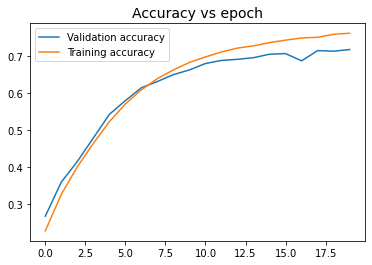

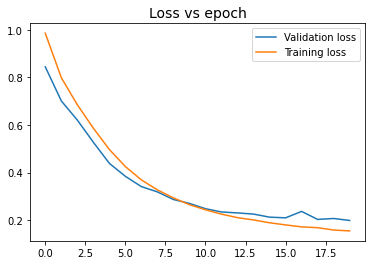

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.15488
accuracy,0.76272
val_loss,0.19882
val_accuracy,0.71867
_runtime,423
_timestamp,1620641439
_step,20
best_val_loss,0.19882
best_epoch,19
inference_val_accuracy,0.29738


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇███████
val_loss,█▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▆▆▇▇▇▇█████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 3pjqwf9i with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 16
wandb: 	num_layers: 3


cell_LSTM_ncell_16_nlayer_3_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 43s - loss: 1.1458 - accuracy: 0.1694 - val_loss: 1.0328 - val_accuracy: 0.1911
Epoch 2/20
647/647 - 19s - loss: 1.0381 - accuracy: 0.2198 - val_loss: 0.9411 - val_accuracy: 0.2371
Epoch 3/20
647/647 - 19s - loss: 0.9499 - accuracy: 0.2576 - val_loss: 0.8821 - val_accuracy: 0.2651
Epoch 4/20
647/647 - 18s - loss: 0.9000 - accuracy: 0.2851 - val_loss: 0.8397 - val_accuracy: 0.2925
Epoch 5/20
647/647 - 19s - loss: 0.8569 - accuracy: 0.3103 - val_loss: 0.7898 - val_accuracy: 0.3187
Epoch 6/20
647/647 - 18s - loss: 0.8054 - accuracy: 0.3316 - val_loss: 0.7513 - val_accuracy: 0.3409
Epoch 7/20
647/647 - 18s - loss: 0.7651 - accuracy: 0.3539 - val_loss: 0.7458 - val_accuracy: 0.3371
Epoch 8/20
647/647 - 18s - loss: 0.7362 - accuracy: 0.3725 - val_loss: 0.6863 - val_accuracy: 0.3828
Epoch 9/20
647/647 - 19s - loss: 0.7047 - accuracy: 0.3934 - val_loss: 0.6694 - val_accuracy: 0.3936
Epoch 10/20
647/647 - 18s - loss: 0.6867 - acc

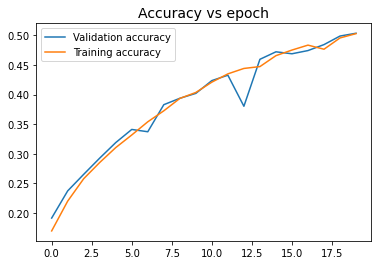

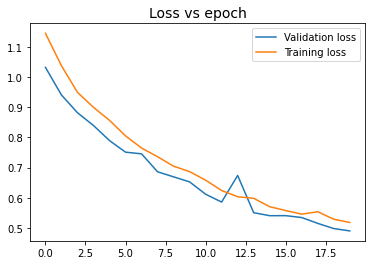

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.51803
accuracy,0.50298
val_loss,0.49003
val_accuracy,0.50362
_runtime,431
_timestamp,1620641878
_step,20
best_val_loss,0.49003
best_epoch,19
inference_val_accuracy,0.02523


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
accuracy,▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇█▇██
val_loss,█▇▆▆▅▄▄▄▃▃▃▂▃▂▂▂▂▁▁▁
val_accuracy,▁▂▃▃▄▄▄▅▆▆▆▆▅▇▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: wa1e6r9z with config:
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 32
wandb: 	num_cells: 16
wandb: 	num_layers: 2


cell_GRU_ncell_16_nlayer_2_emb_32_dp_0_bm_3
Epoch 1/20
647/647 - 32s - loss: 1.1401 - accuracy: 0.1613 - val_loss: 0.9757 - val_accuracy: 0.2154
Epoch 2/20
647/647 - 13s - loss: 0.9530 - accuracy: 0.2471 - val_loss: 0.8648 - val_accuracy: 0.2655
Epoch 3/20
647/647 - 13s - loss: 0.8751 - accuracy: 0.2845 - val_loss: 0.8113 - val_accuracy: 0.2967
Epoch 4/20
647/647 - 13s - loss: 0.8268 - accuracy: 0.3126 - val_loss: 0.7659 - val_accuracy: 0.3261
Epoch 5/20
647/647 - 13s - loss: 0.7805 - accuracy: 0.3412 - val_loss: 0.7197 - val_accuracy: 0.3517
Epoch 6/20
647/647 - 13s - loss: 0.7340 - accuracy: 0.3683 - val_loss: 0.6787 - val_accuracy: 0.3761
Epoch 7/20
647/647 - 13s - loss: 0.6920 - accuracy: 0.3891 - val_loss: 0.6438 - val_accuracy: 0.3921
Epoch 8/20
647/647 - 13s - loss: 0.6575 - accuracy: 0.4071 - val_loss: 0.6105 - val_accuracy: 0.4153
Epoch 9/20
647/647 - 13s - loss: 0.6291 - accuracy: 0.4236 - val_loss: 0.5851 - val_accuracy: 0.4267
Epoch 10/20
647/647 - 13s - loss: 0.6039 - accu

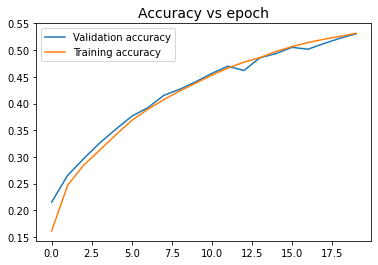

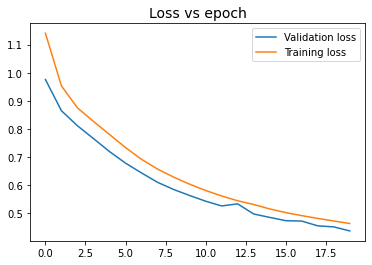

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.46417
accuracy,0.53163
val_loss,0.43785
val_accuracy,0.53054
_runtime,306
_timestamp,1620642193
_step,20
best_val_loss,0.43785
best_epoch,19
inference_val_accuracy,0.04767


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
accuracy,▁▃▃▄▄▅▅▆▆▆▇▇▇▇▇█████
val_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▃▄▅▅▅▆▆▆▇▆▇▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: vdaib7e9 with config:
wandb: 	beam_size: 3
wandb: 	cell_type: RNN
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 64
wandb: 	num_layers: 2


cell_RNN_ncell_64_nlayer_2_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 65s - loss: 0.8924 - accuracy: 0.2959 - val_loss: 0.7383 - val_accuracy: 0.3524
Epoch 2/20
647/647 - 61s - loss: 0.6794 - accuracy: 0.4126 - val_loss: 0.6007 - val_accuracy: 0.4346
Epoch 3/20
647/647 - 61s - loss: 0.5810 - accuracy: 0.4645 - val_loss: 0.5845 - val_accuracy: 0.4360
Epoch 4/20
647/647 - 60s - loss: 0.5382 - accuracy: 0.4879 - val_loss: 0.4936 - val_accuracy: 0.4978
Epoch 5/20
647/647 - 60s - loss: 0.4915 - accuracy: 0.5171 - val_loss: 0.4580 - val_accuracy: 0.5195
Epoch 6/20
647/647 - 61s - loss: 0.4631 - accuracy: 0.5345 - val_loss: 0.4304 - val_accuracy: 0.5367
Epoch 7/20
647/647 - 61s - loss: 0.4374 - accuracy: 0.5514 - val_loss: 0.4257 - val_accuracy: 0.5442
Epoch 8/20
647/647 - 60s - loss: 0.4224 - accuracy: 0.5604 - val_loss: 0.4059 - val_accuracy: 0.5571
Epoch 9/20
647/647 - 61s - loss: 0.4077 - accuracy: 0.5698 - val_loss: 0.3972 - val_accuracy: 0.5634
Epoch 10/20
647/647 - 61s - loss: 0.3945 - accu

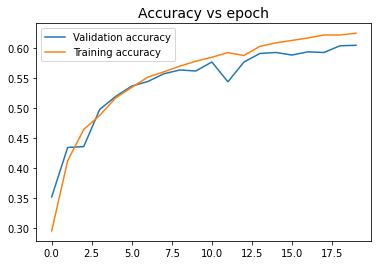

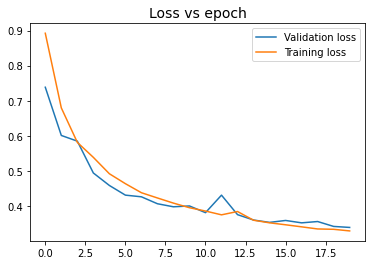

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.32835
accuracy,0.6245
val_loss,0.33828
val_accuracy,0.60446
_runtime,1232
_timestamp,1620643433
_step,20
best_val_loss,0.33828
best_epoch,19
inference_val_accuracy,0.11687


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▃▃▂▂▂▂▃▂▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▆▆▆▇▇▇▇▆▇███████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 53vwa605 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 64
wandb: 	num_layers: 3


cell_GRU_ncell_64_nlayer_3_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 43s - loss: 0.9601 - accuracy: 0.2438 - val_loss: 0.7742 - val_accuracy: 0.3074
Epoch 2/20
647/647 - 18s - loss: 0.7209 - accuracy: 0.3814 - val_loss: 0.6096 - val_accuracy: 0.4302
Epoch 3/20
647/647 - 19s - loss: 0.5656 - accuracy: 0.4802 - val_loss: 0.4825 - val_accuracy: 0.5128
Epoch 4/20
647/647 - 18s - loss: 0.4570 - accuracy: 0.5498 - val_loss: 0.4006 - val_accuracy: 0.5751
Epoch 5/20
647/647 - 18s - loss: 0.3789 - accuracy: 0.6026 - val_loss: 0.3455 - val_accuracy: 0.6121
Epoch 6/20
647/647 - 19s - loss: 0.3227 - accuracy: 0.6401 - val_loss: 0.2971 - val_accuracy: 0.6476
Epoch 7/20
647/647 - 18s - loss: 0.2828 - accuracy: 0.6682 - val_loss: 0.2720 - val_accuracy: 0.6629
Epoch 8/20
647/647 - 18s - loss: 0.2544 - accuracy: 0.6885 - val_loss: 0.2519 - val_accuracy: 0.6760
Epoch 9/20
647/647 - 19s - loss: 0.2329 - accuracy: 0.7036 - val_loss: 0.2544 - val_accuracy: 0.6717
Epoch 10/20
647/647 - 21s - loss: 0.2206 - accu

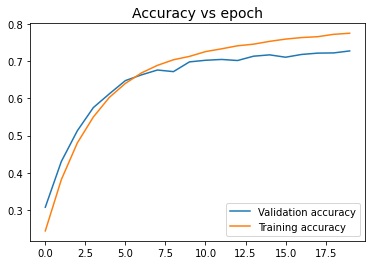

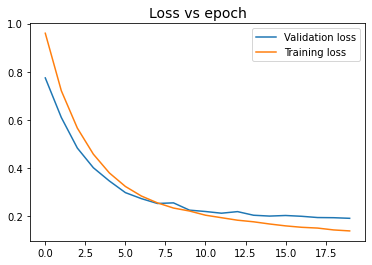

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.13774
accuracy,0.77482
val_loss,0.19016
val_accuracy,0.7273
_runtime,439
_timestamp,1620643880
_step,20
best_val_loss,0.19016
best_epoch,19
inference_val_accuracy,0.31428


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████
val_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▇▇▇▇███████████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gr34ya4n with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 64
wandb: 	num_cells: 32
wandb: 	num_layers: 3


cell_GRU_ncell_32_nlayer_3_emb_64_dp_0_bm_1
Epoch 1/20
647/647 - 45s - loss: 1.0127 - accuracy: 0.2153 - val_loss: 0.8613 - val_accuracy: 0.2479
Epoch 2/20
647/647 - 19s - loss: 0.8136 - accuracy: 0.2948 - val_loss: 0.7431 - val_accuracy: 0.3087
Epoch 3/20
647/647 - 19s - loss: 0.7239 - accuracy: 0.3512 - val_loss: 0.6528 - val_accuracy: 0.3733
Epoch 4/20
647/647 - 19s - loss: 0.6572 - accuracy: 0.3977 - val_loss: 0.5921 - val_accuracy: 0.4187
Epoch 5/20
647/647 - 19s - loss: 0.5995 - accuracy: 0.4403 - val_loss: 0.5473 - val_accuracy: 0.4532
Epoch 6/20
647/647 - 19s - loss: 0.5529 - accuracy: 0.4760 - val_loss: 0.5083 - val_accuracy: 0.4842
Epoch 7/20
647/647 - 19s - loss: 0.5085 - accuracy: 0.5102 - val_loss: 0.4770 - val_accuracy: 0.5045
Epoch 8/20
647/647 - 19s - loss: 0.4689 - accuracy: 0.5401 - val_loss: 0.4294 - val_accuracy: 0.5480
Epoch 9/20
647/647 - 19s - loss: 0.4333 - accuracy: 0.5635 - val_loss: 0.4025 - val_accuracy: 0.5677
Epoch 10/20
647/647 - 19s - loss: 0.4053 - accu

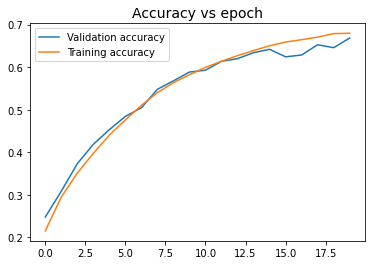

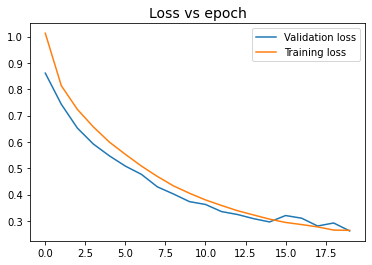

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.26441
accuracy,0.67955
val_loss,0.26226
val_accuracy,0.66829
_runtime,444
_timestamp,1620644342
_step,20
best_val_loss,0.26226
best_epoch,19
inference_val_accuracy,0.20805


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▄▅▅▆▆▇▇▇▇▇██████
val_loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▁▂▂▁▁▁
val_accuracy,▁▂▃▄▄▅▅▆▆▇▇▇▇▇█▇▇███
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: 9x1bhgww with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 32
wandb: 	num_layers: 2


cell_LSTM_ncell_32_nlayer_2_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 34s - loss: 1.0759 - accuracy: 0.1985 - val_loss: 0.9297 - val_accuracy: 0.2249
Epoch 2/20
647/647 - 14s - loss: 0.9143 - accuracy: 0.2630 - val_loss: 0.8269 - val_accuracy: 0.2814
Epoch 3/20
647/647 - 14s - loss: 0.8094 - accuracy: 0.3218 - val_loss: 0.7168 - val_accuracy: 0.3553
Epoch 4/20
647/647 - 14s - loss: 0.6929 - accuracy: 0.3874 - val_loss: 0.6239 - val_accuracy: 0.4032
Epoch 5/20
647/647 - 14s - loss: 0.6205 - accuracy: 0.4385 - val_loss: 0.5635 - val_accuracy: 0.4500
Epoch 6/20
647/647 - 14s - loss: 0.5718 - accuracy: 0.4712 - val_loss: 0.5431 - val_accuracy: 0.4625
Epoch 7/20
647/647 - 14s - loss: 0.5351 - accuracy: 0.4951 - val_loss: 0.4948 - val_accuracy: 0.5038
Epoch 8/20
647/647 - 14s - loss: 0.5048 - accuracy: 0.5147 - val_loss: 0.4747 - val_accuracy: 0.5131
Epoch 9/20
647/647 - 14s - loss: 0.4777 - accuracy: 0.5313 - val_loss: 0.4467 - val_accuracy: 0.5292
Epoch 10/20
647/647 - 14s - loss: 0.4545 - acc

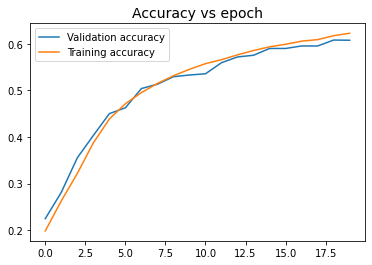

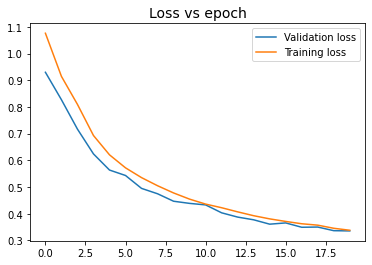

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.33796
accuracy,0.62243
val_loss,0.33548
val_accuracy,0.60742
_runtime,324
_timestamp,1620644675
_step,20
best_val_loss,0.33548
best_epoch,19
inference_val_accuracy,0.10553


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇██████
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇▇██████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Agent Starting Run: nvgekwi1 with config:
wandb: 	beam_size: 1
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 16
wandb: 	num_layers: 3


cell_LSTM_ncell_16_nlayer_3_emb_16_dp_0_bm_1
Epoch 1/20
647/647 - 43s - loss: 1.1364 - accuracy: 0.1786 - val_loss: 1.0188 - val_accuracy: 0.1976
Epoch 2/20
647/647 - 18s - loss: 1.0358 - accuracy: 0.2197 - val_loss: 0.9358 - val_accuracy: 0.2436
Epoch 3/20
647/647 - 17s - loss: 0.9378 - accuracy: 0.2709 - val_loss: 0.8616 - val_accuracy: 0.2732
Epoch 4/20
647/647 - 18s - loss: 0.8720 - accuracy: 0.2997 - val_loss: 0.8081 - val_accuracy: 0.3073
Epoch 5/20
647/647 - 19s - loss: 0.8247 - accuracy: 0.3262 - val_loss: 0.7804 - val_accuracy: 0.3239
Epoch 6/20
647/647 - 19s - loss: 0.7945 - accuracy: 0.3440 - val_loss: 0.7434 - val_accuracy: 0.3499
Epoch 7/20
647/647 - 19s - loss: 0.7639 - accuracy: 0.3635 - val_loss: 0.7178 - val_accuracy: 0.3678
Epoch 8/20
647/647 - 19s - loss: 0.7382 - accuracy: 0.3754 - val_loss: 0.6932 - val_accuracy: 0.3740
Epoch 9/20
647/647 - 19s - loss: 0.7169 - accuracy: 0.3850 - val_loss: 0.6734 - val_accuracy: 0.3838
Epoch 10/20
647/647 - 19s - loss: 0.6981 - acc

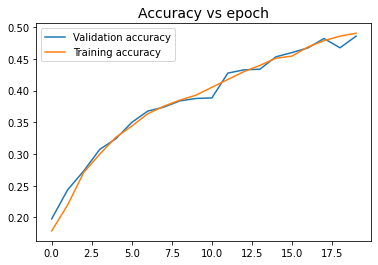

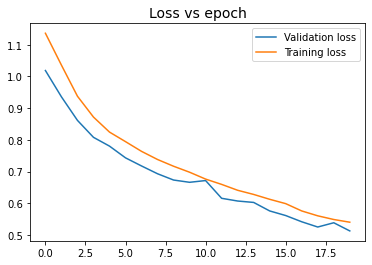

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,19
loss,0.54043
accuracy,0.49063
val_loss,0.51297
val_accuracy,0.486
_runtime,428
_timestamp,1620645112
_step,20
best_val_loss,0.51297
best_epoch,19
inference_val_accuracy,0.02592


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
val_loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
inference_val_accuracy,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c1b4kgan with config:
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout_fraction: 0
wandb: 	input_embedding_size: 16
wandb: 	num_cells: 64
wandb: 	num_layers: 3


cell_LSTM_ncell_64_nlayer_3_emb_16_dp_0_bm_3
Epoch 1/20
647/647 - 45s - loss: 1.0631 - accuracy: 0.2065 - val_loss: 0.8979 - val_accuracy: 0.2512
Epoch 2/20
647/647 - 19s - loss: 0.8489 - accuracy: 0.2980 - val_loss: 0.7361 - val_accuracy: 0.3358
Epoch 3/20
647/647 - 20s - loss: 0.6994 - accuracy: 0.3890 - val_loss: 0.6210 - val_accuracy: 0.4207
Epoch 4/20
647/647 - 20s - loss: 0.6087 - accuracy: 0.4486 - val_loss: 0.5644 - val_accuracy: 0.4512
Epoch 5/20
647/647 - 19s - loss: 0.5393 - accuracy: 0.4964 - val_loss: 0.5002 - val_accuracy: 0.4970
Epoch 6/20
647/647 - 20s - loss: 0.4724 - accuracy: 0.5403 - val_loss: 0.4314 - val_accuracy: 0.5505
Epoch 7/20


In [ ]:
# Sweep configuration
sweep_config = {
  "name": "Assignment3_new",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "cell_type": {
            "values": ["LSTM", "RNN", "GRU"]
        },
        "num_cells": {
            "values": [16, 32, 64]
        },
        "num_layers": {
            "values": [1, 2, 3]
        },
        "input_embedding_size": {
            "values": [16, 32, 64]
        },
        "dropout_fraction": {
            "values": [0]
        },
        "beam_size": {
            "values": [1, 3]
        }
    }
}

# Generates a sweep id
sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment_3")
print(f"Sweep ID = {sweep_id}")
wandb.agent(sweep_id, train_with_wandb, count=100)

# Training the Best Model

Use this to train the model with the best choice of hyperparameters obtained from Wandb.

In [19]:
def train(num_cells, cell_type, num_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    Function to train the model with the best set of hyperparameters (without WANDB)
    """
    # Define the model

    model = define_model(num_cells, cell_type, num_layers, num_layers, input_embedding_size, dropout_fraction, beam_size)
    print(model.summary())

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
            )

    # Save the trained model
    model.save("best_model_seq2seq.h5")

    if cell_type == "LSTM":
        cell = "lstm"
    else:
        cell = "rnngru"

    func1_name = "prepare_inference_model_" + cell + "_" + str(num_layers)
    func2_name = "transliterate_word_" + cell + "_" + str(num_layers)

    # Get the encoder and decoder model
    encoder_model, decoder_model = globals()[func1_name](model, num_cells)

    outputs = []
    n = encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in target_words]
    # Calculate training accuracy
    training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Training accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))


    outputs = []
    n = val_encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = val_encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in val_target_words]
    # Calculate validation accuracy
    validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    return model, history

### Training with the Best Hyperparameters

These are the best hyperparameters that we got from WANDB.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
______________________________________________________________________________________________

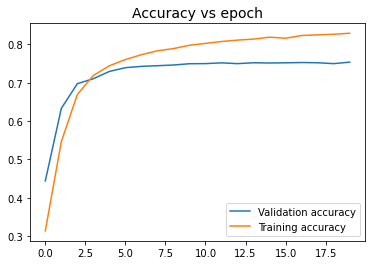

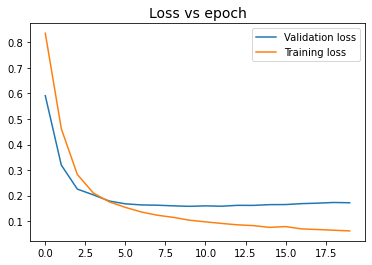

In [20]:
# Best hyperparameters
num_cells = 256
cell_type = "GRU"
num_layers = 2
num_encoder_layers = num_layers
num_decoder_layers = num_layers
input_embedding_size = 32
dropout_fraction = 0.1
beam_size = 1

model, history = train(num_cells, cell_type, num_layers, input_embedding_size, dropout_fraction, beam_size)

### Load the best model



In [23]:
model = keras.models.load_model("best_model_seq2seq.h5")
encoder_model, decoder_model = prepare_inference_model_rnngru_2(model, num_cells)

### Diagram of the Best Model

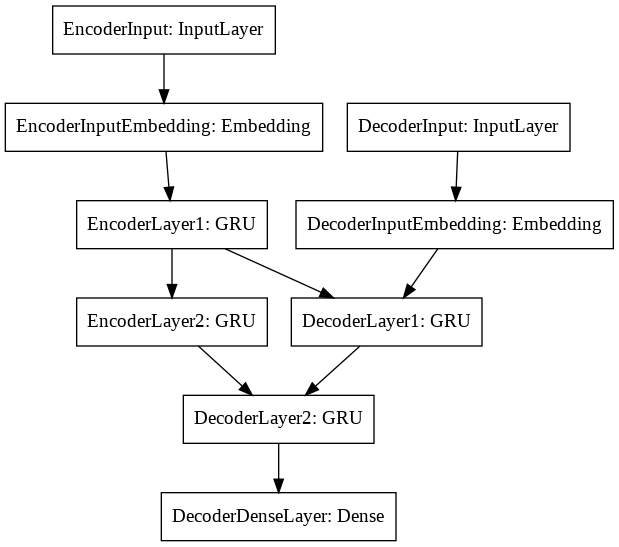

In [24]:
keras.utils.plot_model(model)

### Character-wise accuracy scores

In [25]:
train_eval = model.evaluate([encoder_input_array, decoder_input_array], decoder_output_array)
val_eval = model.evaluate([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
test_eval = model.evaluate([test_encoder_input_array, test_decoder_input_array], test_decoder_output_array)

print("Character-wise training accuracy = {} %".format(train_eval[1]*100.0))
print("Character-wise validation accuracy = {} %".format(val_eval[1]*100.0))
print("Character-wise test accuracy = {} %".format(test_eval[1]*100.0))

139/139 [==============================] - 6s 41ms/step - loss: 0.1694 - accuracy: 0.7517
Character-wise training accuracy = 85.83393692970276 %
Character-wise validation accuracy = 75.37280917167664 %
Character-wise test accuracy = 75.17355680465698 %


### Inference using the best model (Training Set)

In [26]:
outputs = []

n = encoder_input_array.shape[0]
batch_size = 1000

for i in range(0, n, batch_size):
    # Inputs
    query = encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in target_words[:n]]

df_train = pd.DataFrame({"Input": input_words[:n], "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate training accuracy
training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Training Inference accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))

# Save the inference results
df_train.to_csv("TrainingSetPredictions.csv", index=False)

Training Inference accuracy based on whole string matching = 83.71991776514693 %


### Inference using the best model (Validation Set)

In [27]:
outputs = []

n = val_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = val_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in val_target_words]

df_val = pd.DataFrame({"Input": val_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Validation set inference accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

# Save the inference results
df_val.to_csv("ValidationSetPredictions.csv", index=False)

Validation set inference accuracy based on whole string matching = 38.60217542235594 %


### Inference using the best model (Test Set)

In [29]:
outputs = []

n = test_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = test_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in test_target_words]

df_test = pd.DataFrame({"Input": test_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
test_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Test set Inference accuracy based on whole string matching = {} %".format(test_inference_accuracy*100.0))

# Save the inference results
df_test.to_csv("TestSetPredictions.csv", index=False)

Test set Inference accuracy based on whole string matching = 37.57316524088248 %


### Visualize the Test Set results

In [32]:
df_test = pd.read_csv("TestSetPredictions.csv")
df_test = df_test.sample(frac=1)
df_test.head(25)

,Input,Ground Truth,Model output
1300,zamana,ज़माना,जमाना
76,adhivas,अधिवास,अधिवास
4401,hingis,हिंगिस,हिंगिस
3830,vyaghat,व्याघात,व्याघात
2929,bhira,भीरा,भीरा
3359,raatrichar,रात्रिचर,रात्रिचार
3316,ralhan,रल्हन,रालहण
339,aawajen,आवाज़ें,आवाजें
1687,tiwari,तिवारी,तीवारी
1041,grandson,ग्रैंडसन,ग्रांडसों
